In [ ]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 1.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, RocCurveDisplay, auc, recall_score, f1_score

from imblearn import FunctionSampler
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.pipeline import make_pipeline

from skopt import BayesSearchCV
from skopt.space import Integer, Categorical

# Import Dataset

In [ ]:
drive.mount("/content/drive")

df = pd.read_csv("/content/drive/MyDrive/Data Science/1. Telco Customer Churn/Data/TelcoChurn_prep.csv")

pd.set_option("display.max_columns",None)

df

Mounted at /content/drive


,customerID,tenure,MonthlyCharges,TotalCharges,Churn,Gender Male,Is SeniorCitizen,Have Partner,Have Dependents,Have PhoneService,Not Have MultipleLines,Have MultipleLines,Using DSL as InternetService,Using Fiber optic as InternetService,Not Have OnlineSecurity,Have OnlineSecurity,Not Have OnlineBackup,Have OnlineBackup,Not Have DeviceProtection,Have DeviceProtection,Not have TechSupport,Have TechSupport,Not have StreamingTV,Have StreamingTV,Not have StreamingMovies,Have StreamingMovies,One year,Two year,Have PaperlessBilling,Credit card (automatic),Electronic check,Mailed check
0,7590-VHVEG,-1.280248,-1.161694,-0.994194,No,0,0,1,0,0,0,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,0,1,0,1,0
1,5575-GNVDE,0.064303,-0.260878,-0.173740,No,1,0,0,0,1,1,0,1,0,0,1,1,0,0,1,1,0,1,0,1,0,1,0,0,0,0,1
2,3668-QPYBK,-1.239504,-0.363923,-0.959649,Yes,1,0,0,0,1,1,0,1,0,0,1,0,1,1,0,1,0,1,0,1,0,0,0,1,0,0,1
3,7795-CFOCW,0.512486,-0.747850,-0.195248,No,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,1,1,0,1,0,1,0,0,0,0,0
4,9237-HQITU,-1.239504,0.196178,-0.940457,Yes,0,0,0,0,1,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,-0.343137,0.664868,-0.129180,No,1,0,1,1,1,0,1,1,0,0,1,1,0,0,1,0,1,0,1,0,1,1,0,1,0,0,1
7028,2234-XADUH,1.612573,1.276493,2.241056,No,0,0,1,1,1,0,1,0,1,1,0,0,1,0,1,1,0,0,1,0,1,1,0,1,1,0,0
7029,4801-JZAZL,-0.872808,-1.170004,-0.854514,No,0,0,1,1,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0
7030,8361-LTMKD,-1.158016,0.319168,-0.872095,Yes,1,1,1,0,1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,1


# Drop CustomerID

In [ ]:
df = df.drop(["customerID"],axis=1)

# Ubah Churn

In [ ]:
df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})

# Train Test Split

In [ ]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Balancing imbalace data

KNN adalah model yang sensitif terhadap imbalance dataset, dikarenakan sifatnya yang melihat tetangga terdekat, mari kita analisi terlebih dahulu sebelum memastikan apakah kita akan melakukan handling imbalance dataset atau tidak

analisi akan dilakukan dengan Tolok ukur metode Over-sampling antara lain no sampling, random over sampling, ADSYN, dan SMOTE yang sudah dilakukan StratifiedKFold yang memastikan bahwa proporsi kelas target dalam setiap fold sama dengan proporsi kelas target dalam keseluruhan dataset ini.

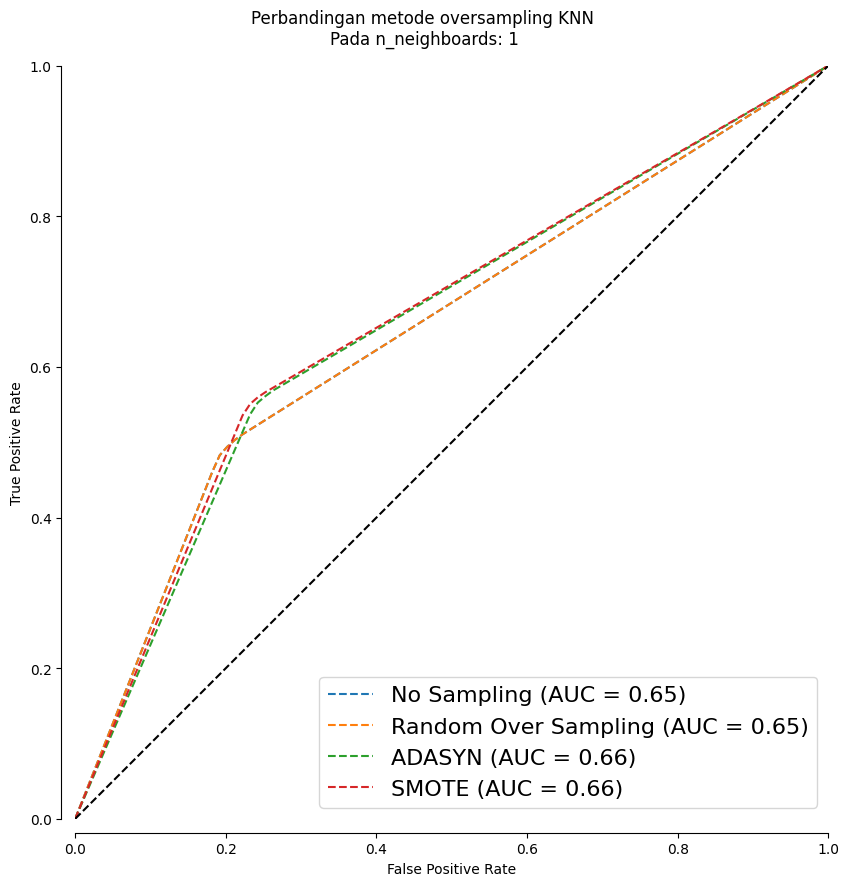

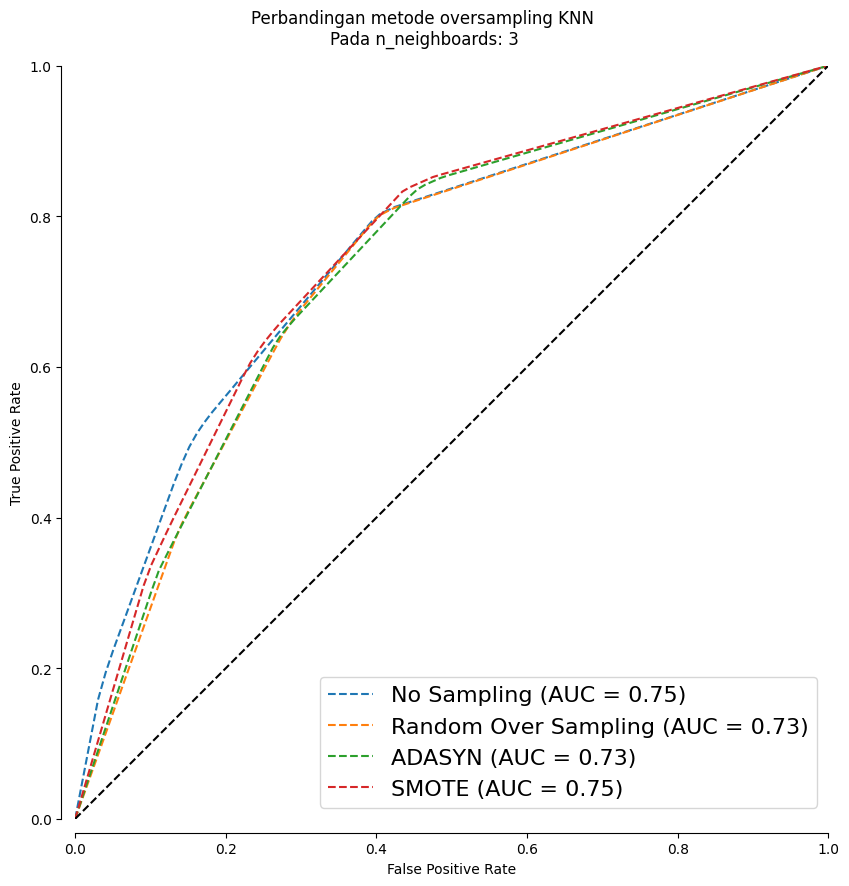

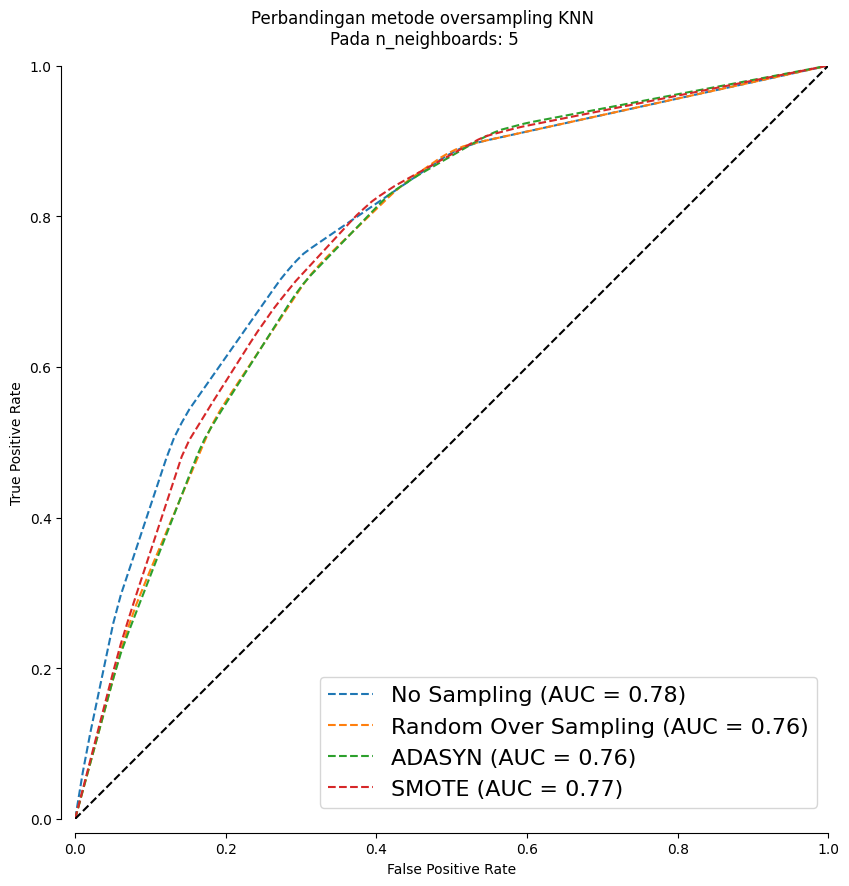

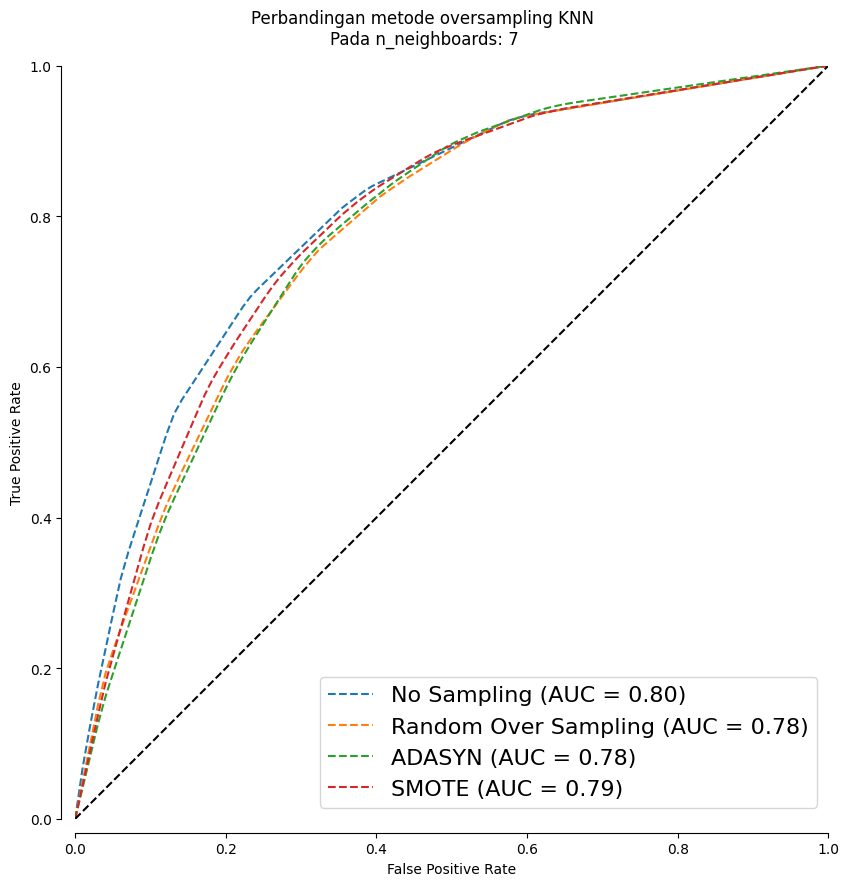

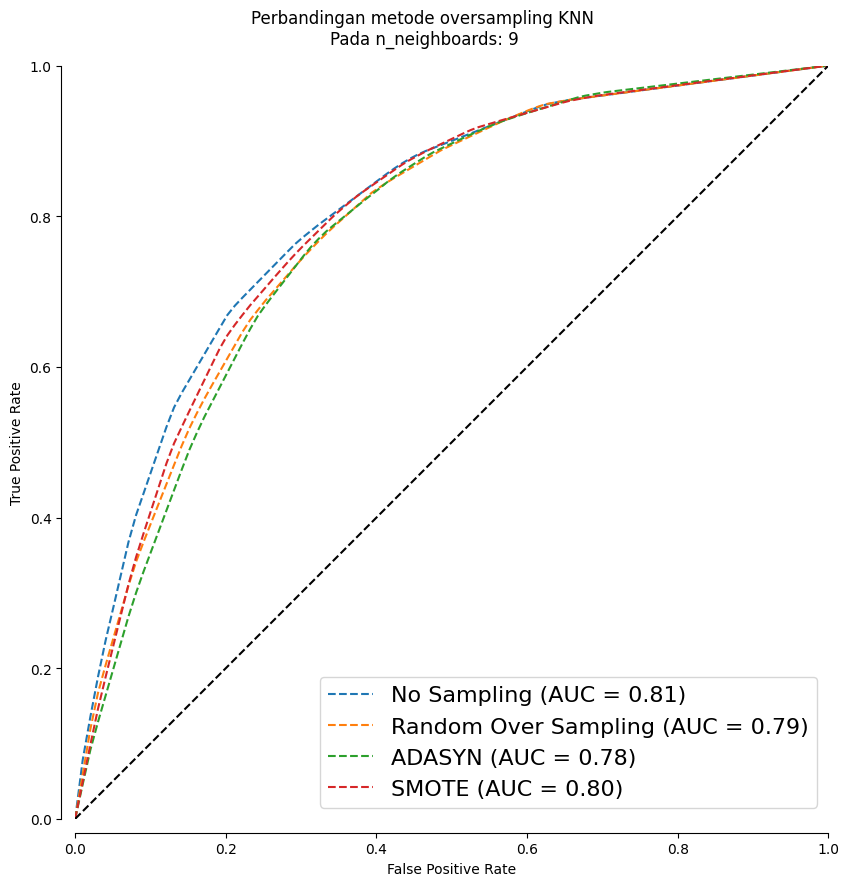

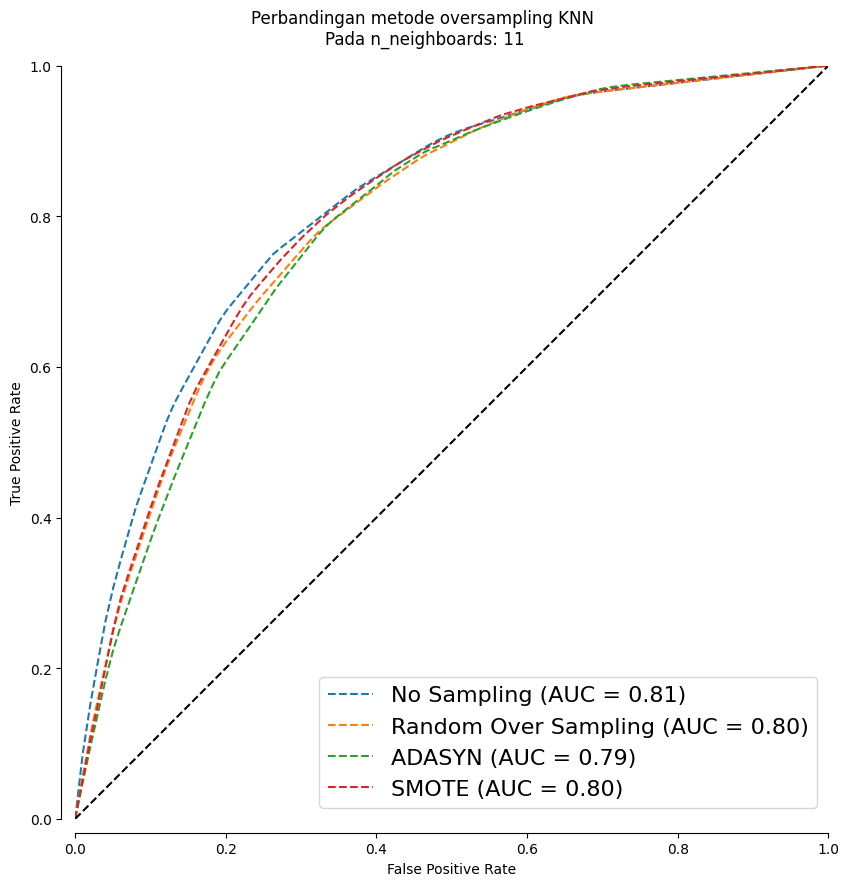

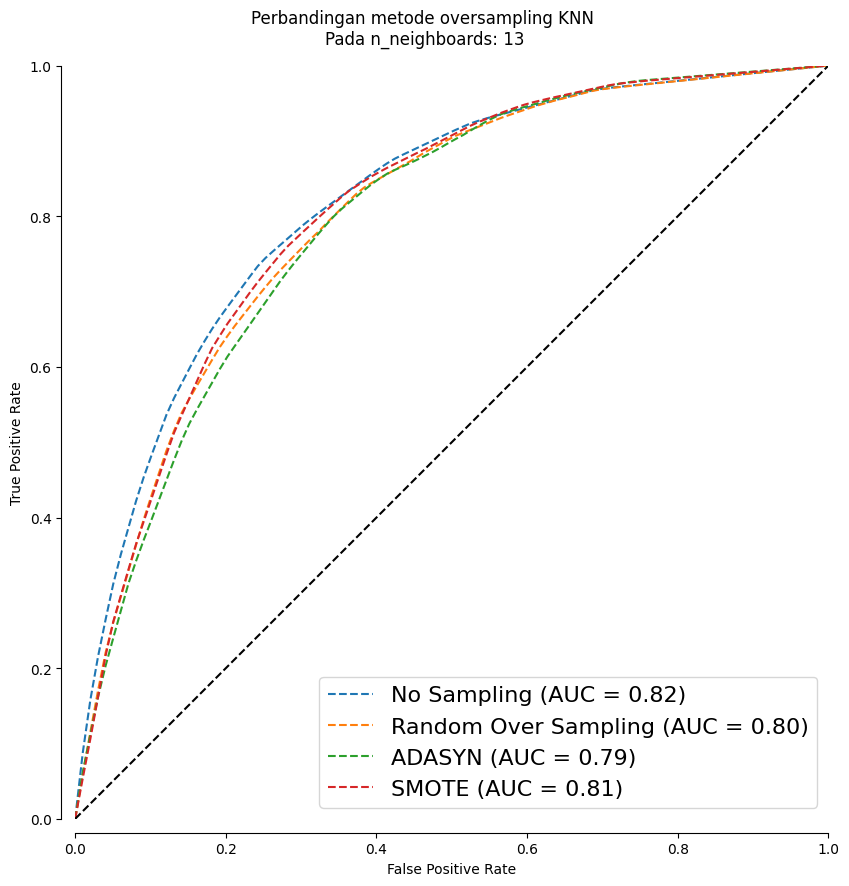

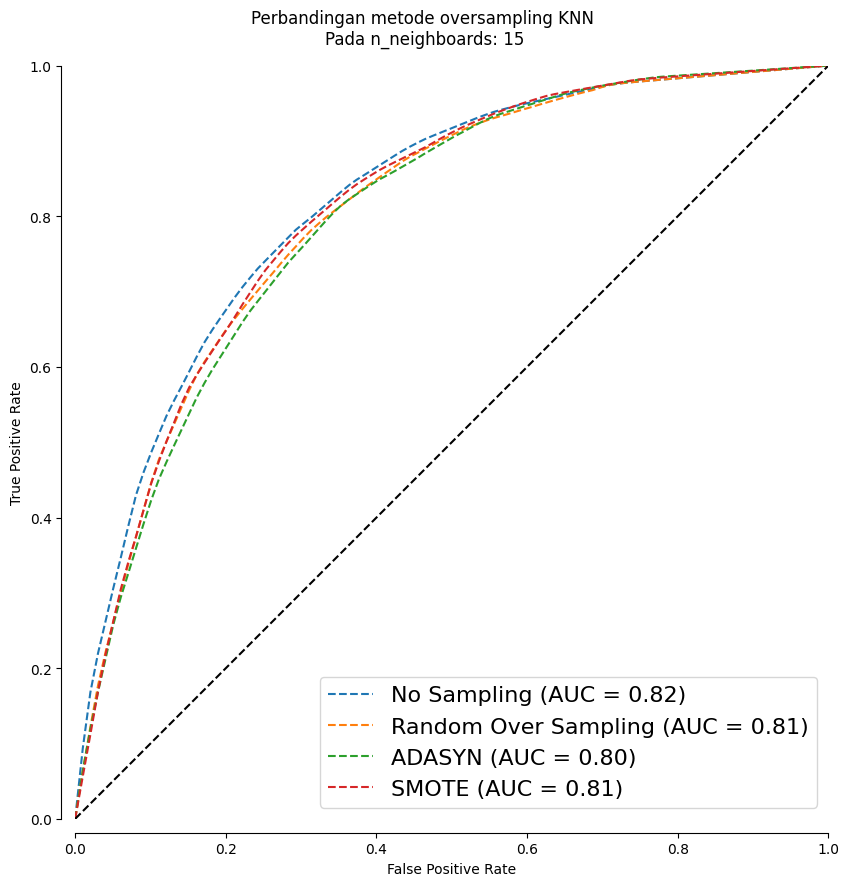

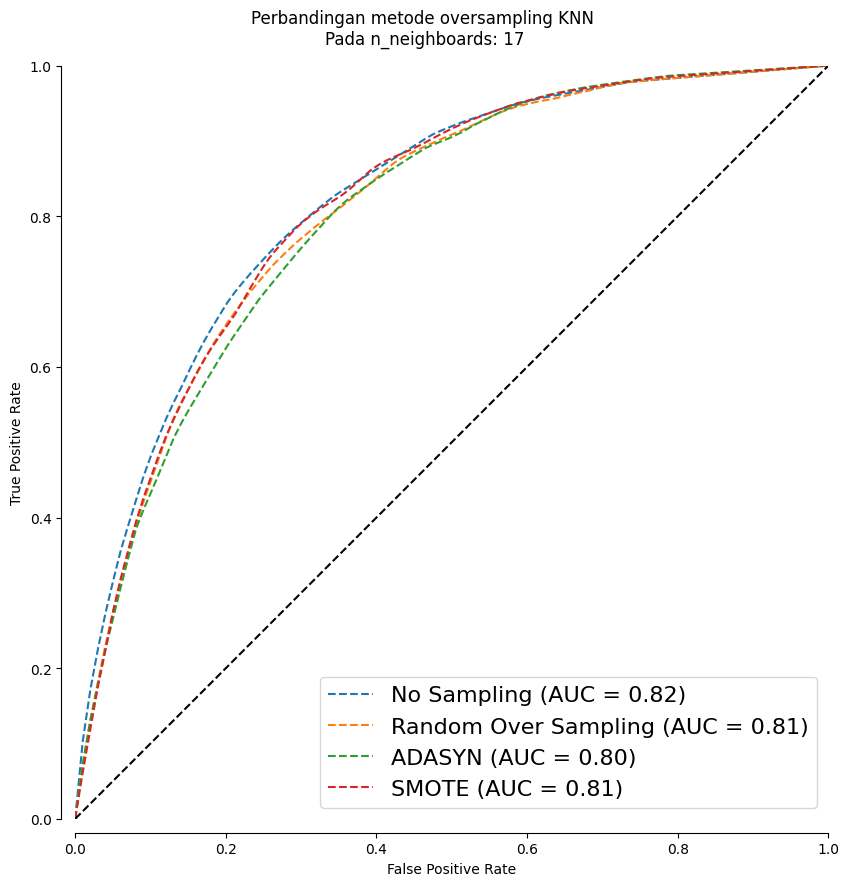

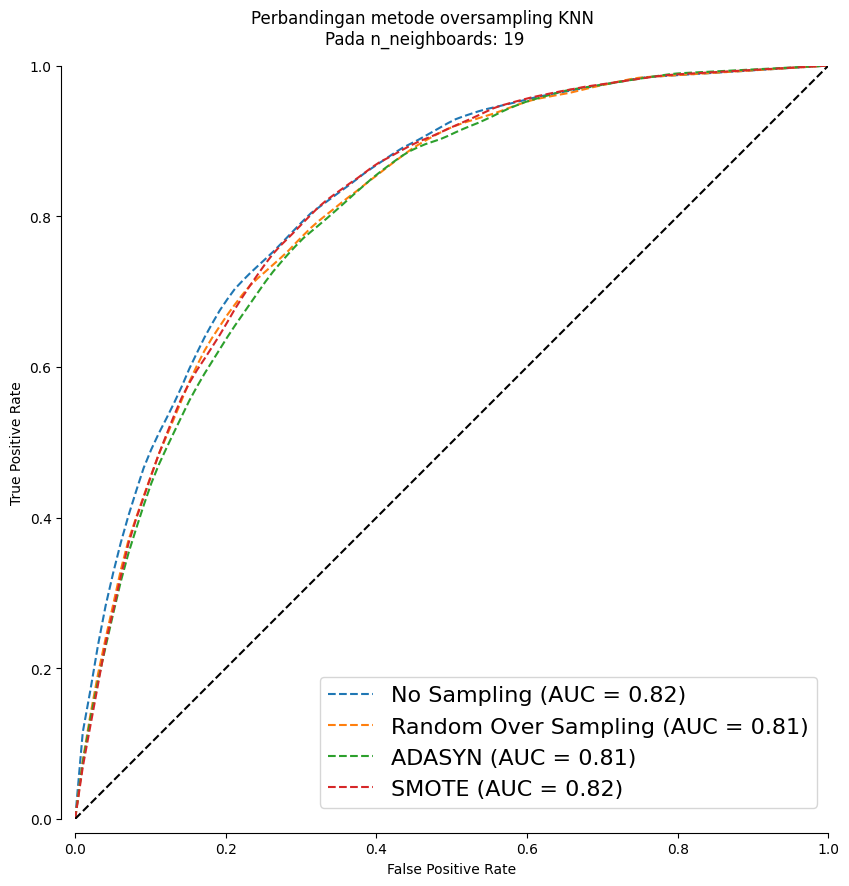

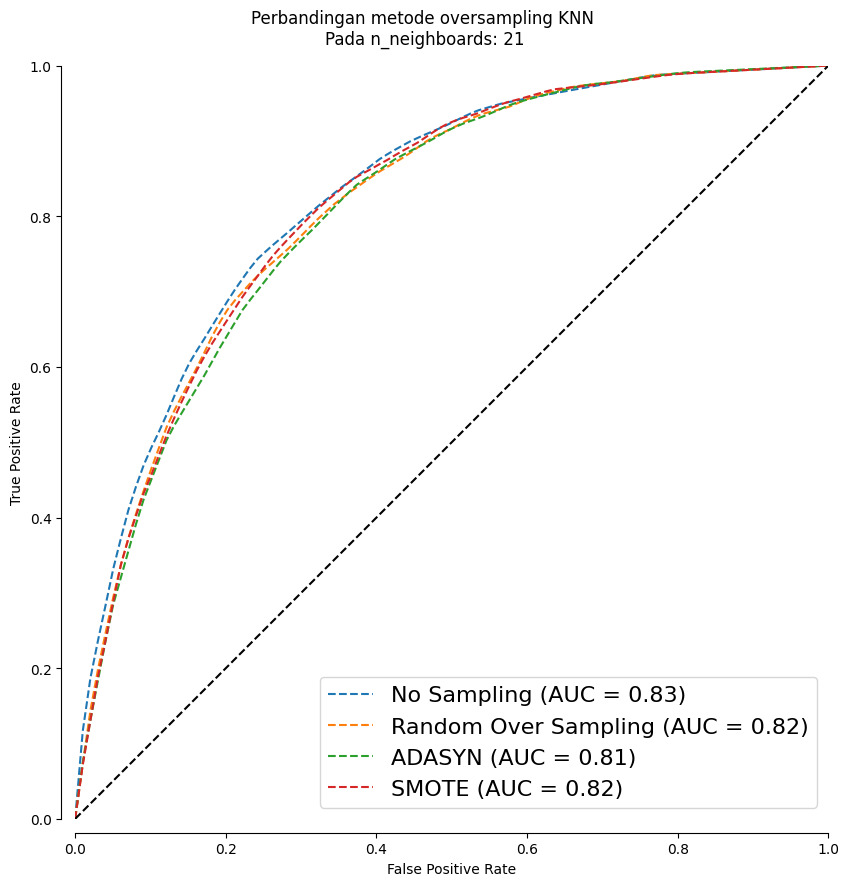

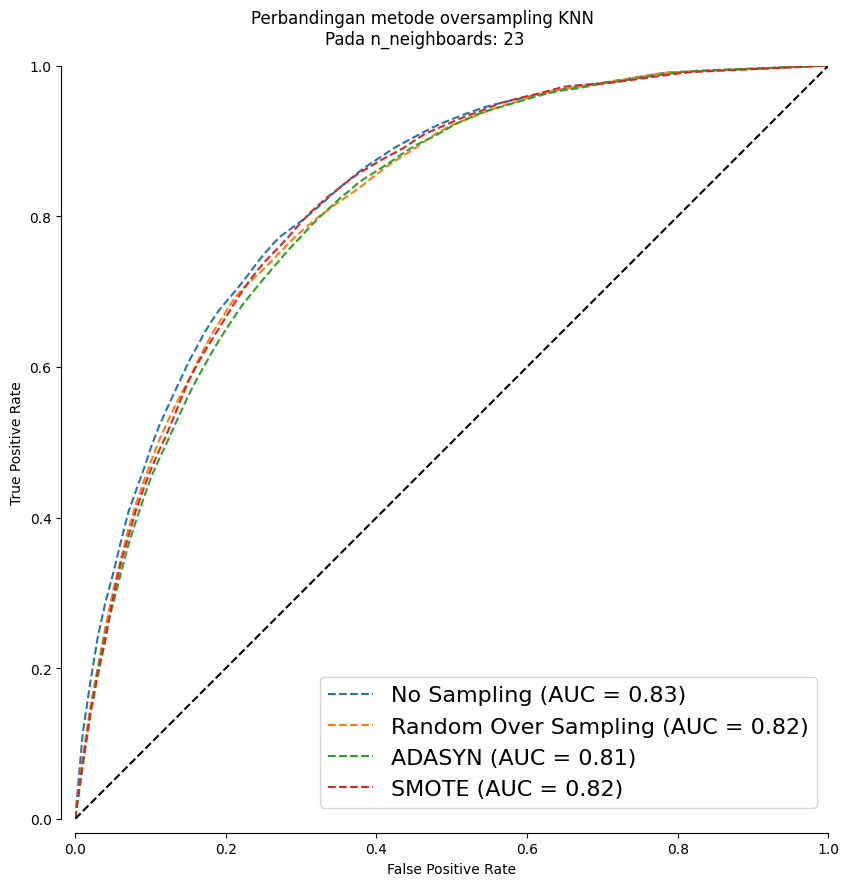

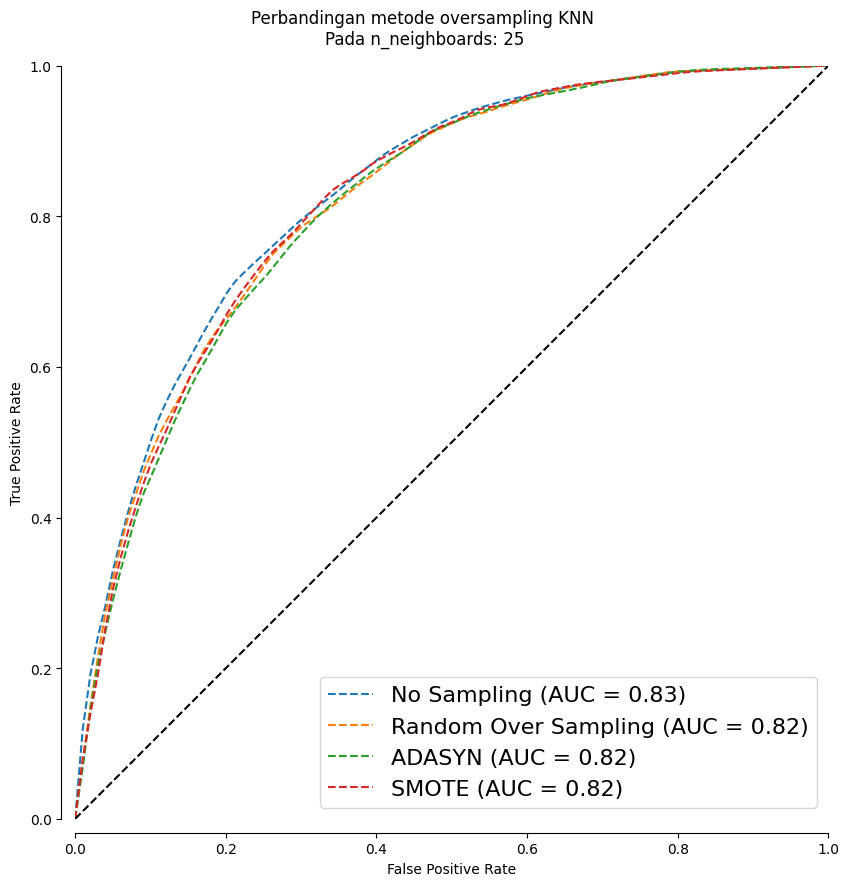

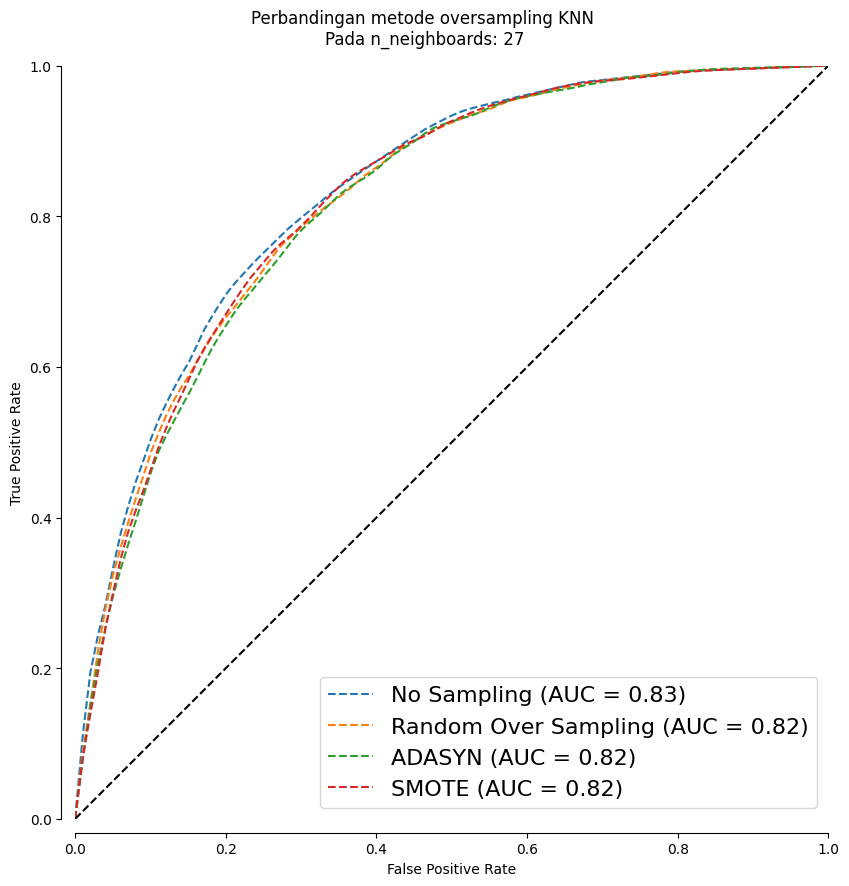

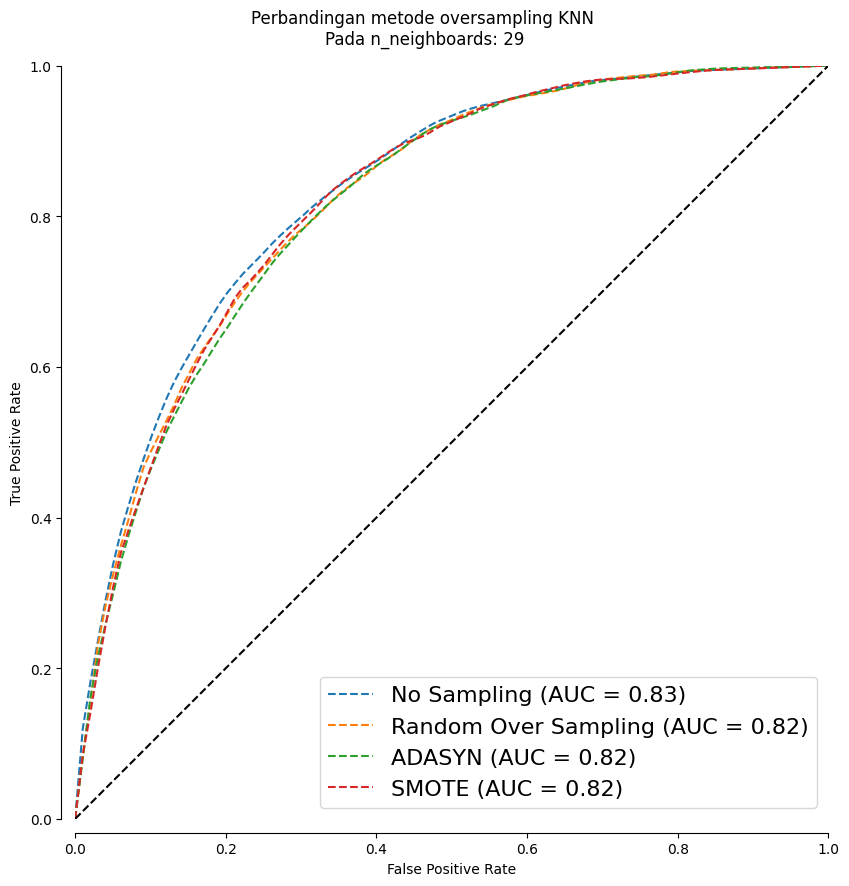

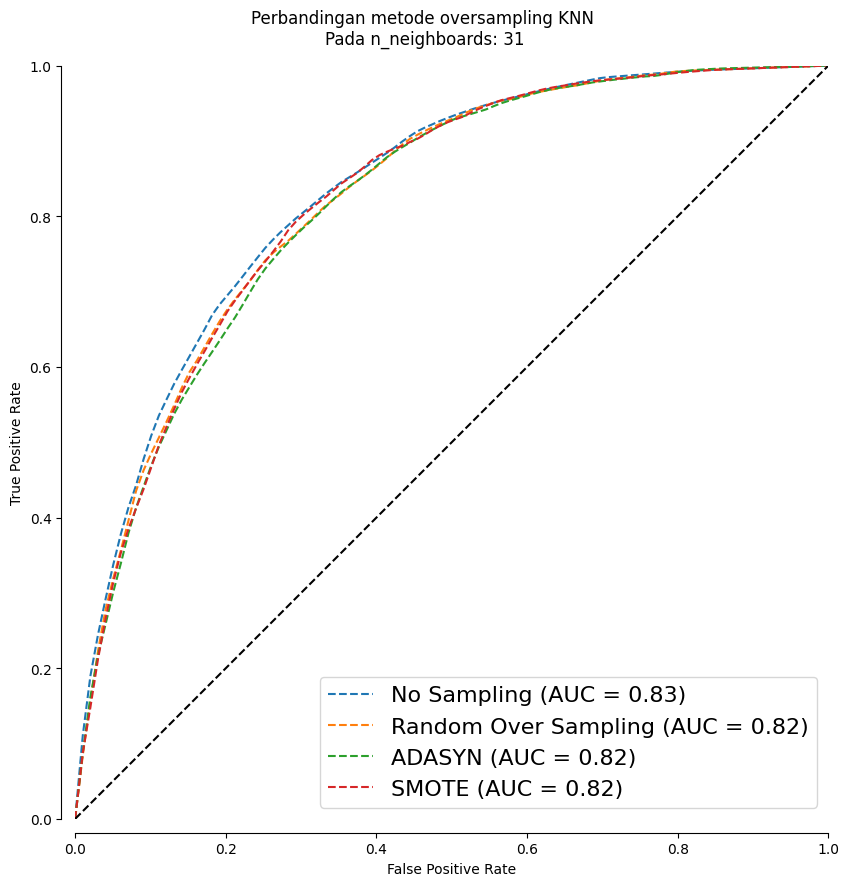

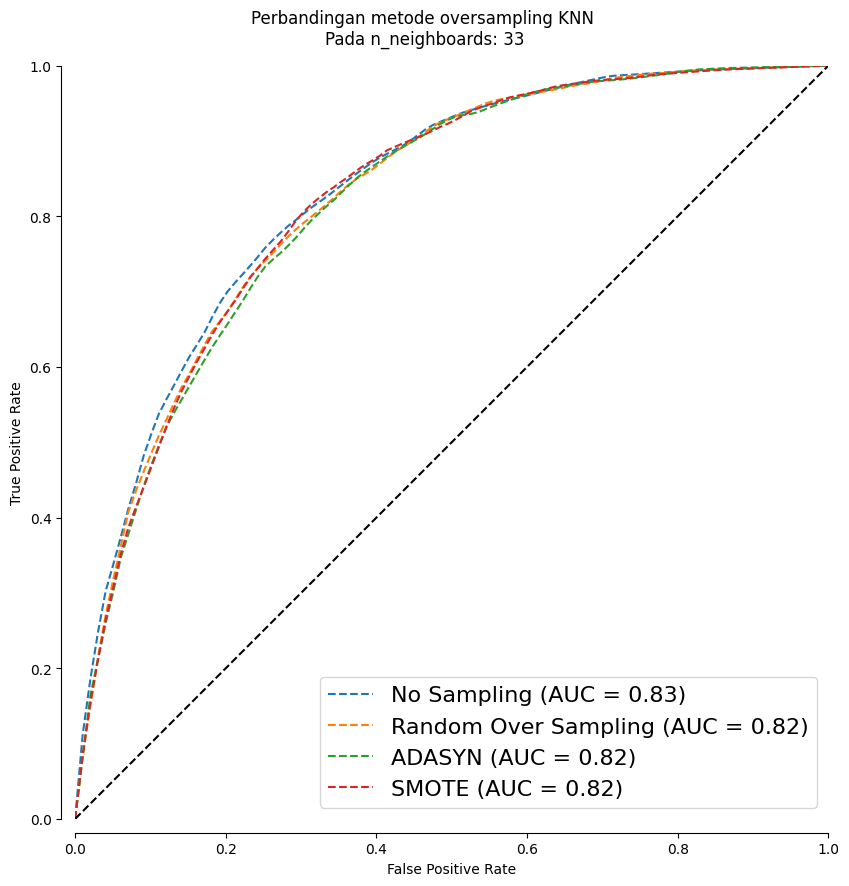

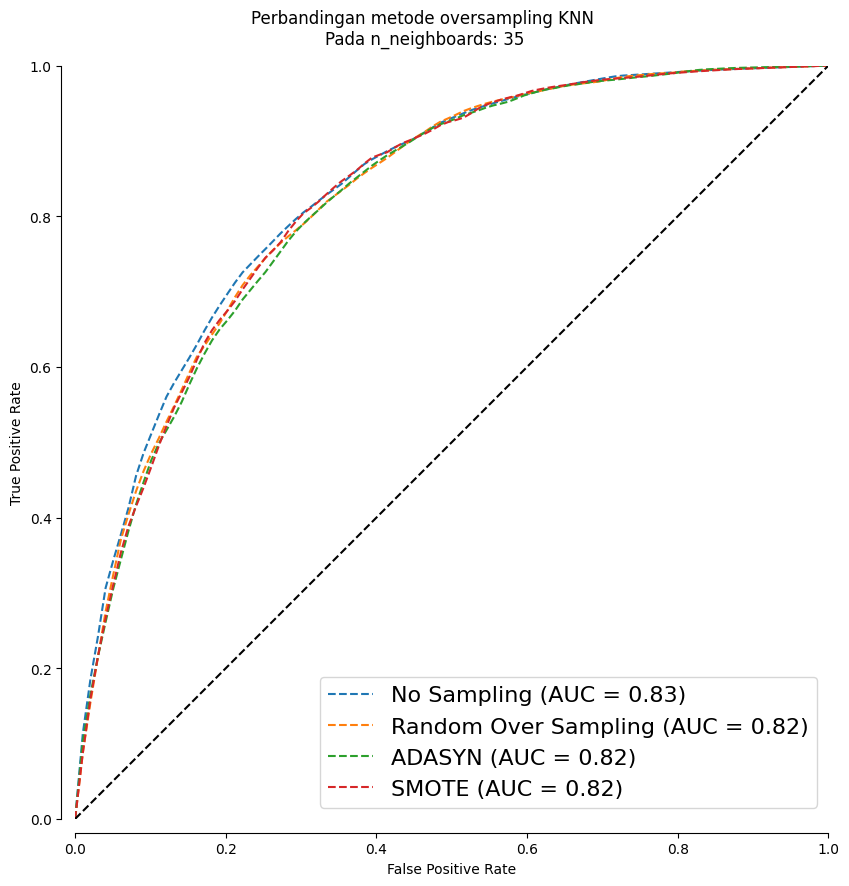

In [ ]:
n_values = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35]
for i in n_values:
  classifier = KNeighborsClassifier(n_neighbors=i)
  cv = StratifiedKFold(n_splits=5)

  pos_label = 1

  pipelines = [
      ('No Sampling', make_pipeline(FunctionSampler(), classifier)),
      ('Random Over Sampling', make_pipeline(RandomOverSampler(random_state=42), classifier)),
      ('ADASYN', make_pipeline(ADASYN(random_state=42), classifier)),
      ('SMOTE', make_pipeline(SMOTE(random_state=42), classifier)),
  ]

  disp = []
  for name, model in pipelines:
      mean_tpr, mean_fpr = 0.0, np.linspace(0, 1, 100)
      for train_index, test_index in cv.split(X, y):
          X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
          y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

          model.fit(X_train_cv, y_train_cv)
          y_proba = model.predict_proba(X_test_cv)

          pos_label_idx = np.flatnonzero(model.classes_ == pos_label)[0]
          fpr, tpr, _ = roc_curve(y_test_cv, y_proba[:, pos_label_idx], pos_label=pos_label)
          mean_tpr += np.interp(mean_fpr, fpr, tpr)
          mean_tpr[0] = 0.0

      mean_tpr /= cv.get_n_splits(X, y)
      mean_tpr[-1] = 1.0
      mean_auc = auc(mean_fpr, mean_tpr)

      disp.append(
          RocCurveDisplay(
              fpr=mean_fpr,
              tpr=mean_tpr,
              roc_auc=mean_auc,
              estimator_name=name,
          )
      )

  fig, ax = plt.subplots(figsize=(9, 9))
  for d in disp:
      d.plot(ax=ax, linestyle="--")
  ax.plot([0, 1], [0, 1], linestyle="--", color="k")
  ax.axis("square")
  fig.suptitle(f"Perbandingan metode oversampling KNN \nPada n_neighboards: {i}")
  ax.set_xlim([0, 1])
  ax.set_ylim([0, 1])
  sns.despine(offset=10, ax=ax)
  plt.legend(loc="lower right", fontsize=16)
  plt.tight_layout()
  plt.show()

Kode di atas adalah benchmark(tolak ukur) untuk metode over-sampling, Tujuan dari tolok ukur ini adalah untuk mengevaluasi apakah penerapan metode over-sampling (seperti Random Over Sampling, ADASYN, dan SMOTE) meningkatkan performa model KNN dibandingkan dengan tidak melakukan penanganan ketidakseimbangan data sama sekali, hasil eksperimen digunakan untuk memahami dampak berbagai metode oversampling pada kinerja KNN menggunakan metrik ROC-AUC

dari hasil di atas..kita dapat menarik kesimpulan bahwa Semua metode over-sampling (Random Over Sampling, ADASYN, SMOTE) memberikan performa yang sangat mirip dengan No Sampling, dengan AUC yang sedikit lebih rendah atau sama.
Ini juga menunjukkan bahwa metode No Sampling sedikit lebih baik dalam hal AUC dibandingkan dengan metode oversampling lainnya. Namun, perbedaannya tidak terlalu signifikan

dengan kata lain, pada dataset ini nampaknya tidak diperlukan adalah handling imbalance dataset(dalam kasus ini over-sampling), dikarenakan nilai yang 11/12, bahkan kebanyakn menunjjukan nilai AUC yang lebih tinggi ketika tidak dilakukan over-sampling

adapun itu hanyalah hipotesis, dikarenakan tujuan awal dari membuat model ini adalah Klasifikasi pada cutomer yang berpotensi churn, mari kita liat nilai recall dan matriks-kesamaan dari perbandingan model yang dilakukan oversampling dan tidak

## Testing performa model no sampling VS SMOTE

Testing performa akan menggunakan parameter n_neigbors=21, sedangkan untuk parameter lainnya akan bernilai default

### No sampling

#### No sampling dan no cv

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

knn = KNeighborsClassifier(n_neighbors=21)

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(f"f1 score(no SMOTE dan no cv):{f1_score(y_test, y_pred)}")
print("\n")
print(f"Confusion matrix(no SMOTE dan no cv):\n{confusion_matrix(y_test, y_pred)}")
print("\n")
print(f"classification report(no SMOTE dan no cv):\n{classification_report(y_test, y_pred)}")
print("\n")
print(f"recall score(no SMOTE dan no cv):{recall_score(y_test,y_pred)}")

f1 score(no SMOTE dan no cv):0.5735567970204842


Confusion matrix(no SMOTE dan no cv):
[[1344  205]
 [ 253  308]]


classification report(no SMOTE dan no cv):
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1549
           1       0.60      0.55      0.57       561

    accuracy                           0.78      2110
   macro avg       0.72      0.71      0.71      2110
weighted avg       0.78      0.78      0.78      2110



recall score(no SMOTE dan no cv):0.5490196078431373


**Kinerja Tanpa Cross-Validation**

- Model KNN memiliki F1 Score sebesar 0.5736 dan Recall Score sebesar 0.5490 pada kelas minoritas (1).

- Confusion matrix menunjukkan bahwa dari 561 sampel kelas 1, model hanya dapat memprediksi 308 sampel dengan benar (true positive), sedangkan 253 sampel salah prediksi (false negative).

#### No sampling dengan cv

In [ ]:
cv = StratifiedKFold(n_splits=15)
cross_val_scores = cross_val_score(knn, X_train, y_train, cv=cv, scoring="f1")
print("Cross-validation f1 Scores:\n", cross_val_scores)
print("\nMean Cross-validation f1 Score:", cross_val_scores.mean())

y_pred = cross_val_predict(knn, X_train, y_train,cv=cv)
print(f"\nconfusion_matrix(no sampling dan no SMOTE):\n{confusion_matrix(y_train, y_pred)}")

cross_val_scores = cross_val_score(knn, X_train, y_train, cv=cv, scoring="recall")
print("Cross-validation Recall Scores:\n", cross_val_scores)
print("\nMean Cross-validation Recall Score:", cross_val_scores.mean())

Cross-validation f1 Scores:
 [0.63855422 0.58385093 0.59550562 0.64670659 0.57303371 0.50909091
 0.49689441 0.65030675 0.50299401 0.6        0.60240964 0.64327485
 0.6091954  0.63529412 0.62576687]

Mean Cross-validation f1 Score: 0.5941918682767718

confusion_matrix(no sampling dan no SMOTE):
[[3158  456]
 [ 562  746]]
Cross-validation Recall Scores:
 [0.60227273 0.53409091 0.60227273 0.62068966 0.5862069  0.48275862
 0.45977011 0.6091954  0.48275862 0.55172414 0.57471264 0.63218391
 0.6091954  0.62068966 0.5862069 ]

Mean Cross-validation Recall Score: 0.5703152211772902


**Kinerja dengan Cross-Validation**

- Rata-rata F1 Score pada cross-validation adalah 0.5942, sedikit lebih tinggi dibandingkan tanpa cross-validation.

- Rata-rata Recall Score pada cross-validation adalah 0.5703, juga sedikit lebih tinggi dibandingkan tanpa cross-validation.

- Confusion matrix menunjukkan hasil serupa dengan lebih banyak data (menggabungkan semua fold).


Meskipun tanpa metode oversampling, performa model cukup baik, namun Recall Score untuk kelas minoritas (1) masih di sekitar 0.55-0.57. Ini berarti hampir separuh dari kelas minoritas tidak terdeteksi dengan baik.

Berdasarkan hasil ROC sebelumnya, metode oversampling tidak memberikan peningkatan signifikan, namun kita akan uji kembali untuk memastikan.

### SMOTE

#### No cv

In [ ]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_sm, y_train_sm)

knn = KNeighborsClassifier(n_neighbors=21)
knn.fit(X_train_res, y_train_res)

y_pred_sm = knn.predict(X_test_sm)

print(f"f1 Score (dengan SMOTE dan no cv): {f1_score(y_test_sm, y_pred_sm)}")
print("\n")
print(f"Confusion matrix (dengan SMOTE dan no cv): \n{confusion_matrix(y_test_sm, y_pred_sm)}")
print("\n")
print(f"classification_report (dengan SMOTE dan no cv): \n{classification_report(y_test_sm, y_pred_sm)}")
print("\n")
print(f"recall score (dengan SMOTE dan no cv): {recall_score(y_test_sm,y_pred_sm)}")

f1 Score (dengan SMOTE dan no cv): 0.6009327115256496


Confusion matrix (dengan SMOTE dan no cv): 
[[1060  489]
 [ 110  451]]


classification_report (dengan SMOTE dan no cv): 
              precision    recall  f1-score   support

           0       0.91      0.68      0.78      1549
           1       0.48      0.80      0.60       561

    accuracy                           0.72      2110
   macro avg       0.69      0.74      0.69      2110
weighted avg       0.79      0.72      0.73      2110



recall score (dengan SMOTE dan no cv): 0.803921568627451


**Kinerja SMOTE pada dataset Tanpa Cross-Validation**

- Dengan menerapkan SMOTE, F1 Score meningkat dari 0.5736 menjadi 0.6009 pada evaluasi tanpa cross-validation.

- Recall Score untuk kelas minoritas meningkat signifikan dari 0.5490 menjadi 0.8039 setelah menerapkan SMOTE.

- Setelah SMOTE: False negatives menurun drastis menjadi 110, menunjukkan peningkatan dalam mendeteksi kelas minoritas.

#### Dengan cv

In [ ]:
cv = StratifiedKFold(n_splits=15)
cross_val_scores_sm = cross_val_score(knn, X_train_res, y_train_res, cv=cv, scoring="f1")
print("Cross-validation Recall Scores:\n", cross_val_scores_sm)
print("\nMean Cross-validation Recall Score:", cross_val_scores_sm.mean())

y_pred_cv = cross_val_predict(knn, X_train_res, y_train_res, cv=cv)
print(f"\nconfusion_matrix(SMOTE dan cv):\n{confusion_matrix(y_train_res, y_pred_cv)}")

cross_val_scores_sm = cross_val_score(knn, X_train_res, y_train_res, cv=cv, scoring="recall")
print("\nCross-validation Recall Scores:\n", cross_val_scores_sm)
print("\nMean Cross-validation Recall Score:", cross_val_scores_sm.mean())

Cross-validation Recall Scores:
 [0.78642715 0.79125249 0.77165354 0.77932406 0.78638941 0.83455882
 0.81818182 0.83082707 0.83643123 0.80602637 0.81767956 0.8365019
 0.81191806 0.84410646 0.83548983]

Mean Cross-validation Recall Score: 0.8124511843493717

confusion_matrix(SMOTE dan cv):
[[2532 1082]
 [ 398 3216]]

Cross-validation Recall Scores:
 [0.81742739 0.82572614 0.81327801 0.81327801 0.86307054 0.94190871
 0.93360996 0.91701245 0.93360996 0.8879668  0.92116183 0.91286307
 0.90456432 0.92116183 0.94166667]

Mean Cross-validation Recall Score: 0.8898870447210697


**Kinerja SMOTE pada dataset dengan Cross-Validation**

- Mean Cross-validation F1 Score meningkat menjadi 0.8125 dengan SMOTE, menunjukkan bahwa model lebih stabil dan memiliki performa yang lebih baik di berbagai subset data.

- Mean Cross-validation Recall Score meningkat menjadi 0.8899, yang menunjukkan bahwa model menjadi lebih efektif dalam mendeteksi kelas minoritas setelah menerapkan SMOTE.


**kesimpulan**

Saat menggunakan SMOTE, recall untuk kelas minoritas meningkat secara signifikan dari 0.55 menjadi 0.80. Namun, precision untuk kelas minoritas menurun dari 0.60 menjadi 0.48. Ini berarti

- Setelah menerapkan SMOTE, recall meningkat signifikan. Ini berarti model menjadi jauh lebih baik dalam mendeteksi pelanggan yang akan churn. Ini sangat penting dalam konteks customer churn karena tujuan utama adalah mengidentifikasi sebanyak mungkin pelanggan yang berisiko agar Anda dapat mengambil tindakan untuk mempertahankan mereka.

- Meskipun precision sedikit menurun, peningkatan recall memberikan manfaat yang lebih besar karena Anda dapat mengidentifikasi lebih banyak pelanggan yang berisiko churn. Dalam kasus ini, false positives lebih bisa diterima dibandingkan dengan false negatives.

**karena bisnis problem di sini adalah mendeteksi pelanggan yang akan churn dan menghindari terlalu banyak false positives, dengan kata lain kita ingin mendeteksi sebanyak mungkin pelanggan yang churn tapi Efisiensi Sumber Daya tetap penting, maka utamannya adalah f1 score**



# Learning Curve

kita akan melihat seluruh learning curve untuk kombinasi berbagai parameter demi mencegah adannya overfitting kedepannya ketika melakukan hyperparameter tunning


## Untuk metric minkowski dan weight uniform

>1, train recall: 0.897, test recall: 0.544
>1, train f1: 0.844, test f1: 0.506
Recall Rentang adalah = 0.353
F1 Rentang adalah = 0.338


>2, train recall: 0.790, test recall: 0.399
>2, train f1: 0.815, test f1: 0.449
Recall Rentang adalah = 0.390
F1 Rentang adalah = 0.367


>3, train recall: 0.916, test recall: 0.663
>3, train f1: 0.847, test f1: 0.561
Recall Rentang adalah = 0.253
F1 Rentang adalah = 0.287


>4, train recall: 0.856, test recall: 0.594
>4, train f1: 0.834, test f1: 0.560
Recall Rentang adalah = 0.263
F1 Rentang adalah = 0.274


>5, train recall: 0.915, test recall: 0.704
>5, train f1: 0.839, test f1: 0.574
Recall Rentang adalah = 0.211
F1 Rentang adalah = 0.265


>6, train recall: 0.871, test recall: 0.633
>6, train f1: 0.833, test f1: 0.560
Recall Rentang adalah = 0.239
F1 Rentang adalah = 0.272


>7, train recall: 0.911, test recall: 0.731
>7, train f1: 0.832, test f1: 0.582
Recall Rentang adalah = 0.180
F1 Rentang adalah = 0.250


>8, train recall: 0.871, test reca

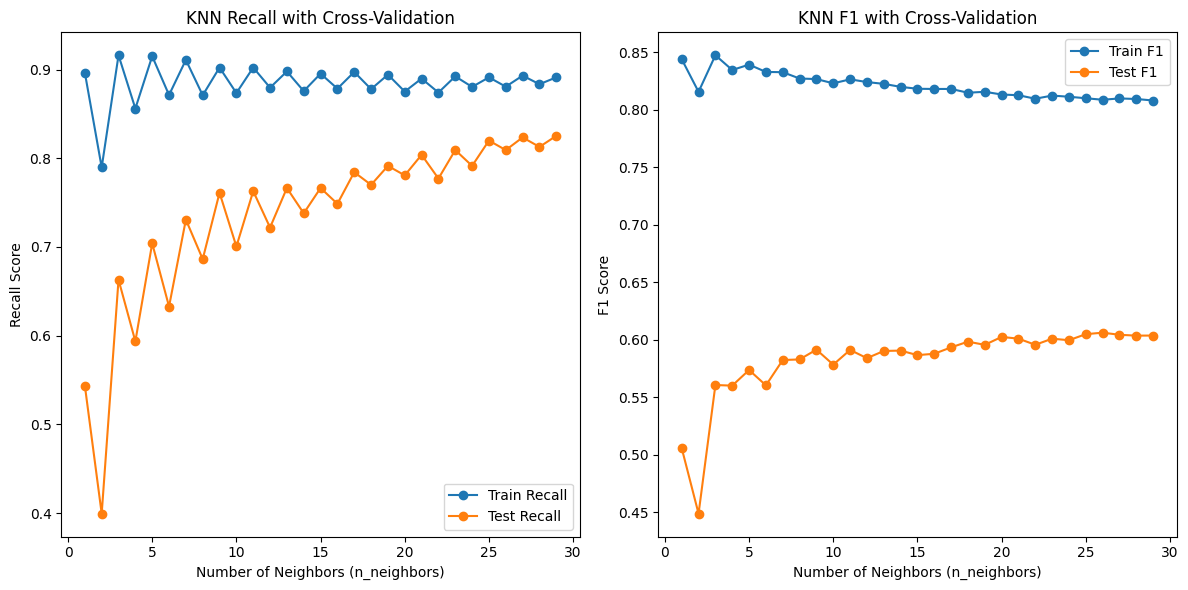

In [ ]:
values = [i for i in range(1, 30)]
train_recalls, test_recalls = list(), list()
train_f1s, test_f1s = list(), list()

cv = StratifiedKFold(n_splits=15)

for i in values:
    model = KNeighborsClassifier(n_neighbors=i, weights="uniform", metric="minkowski")

    train_recalls_cv = cross_val_score(model, X_train_res, y_train_res, cv=cv, scoring="recall")
    train_recall = train_recalls_cv.mean()
    train_recalls.append(train_recall)

    train_f1s_cv = cross_val_score(model, X_train_res, y_train_res, cv=cv, scoring="f1")
    train_f1 = train_f1s_cv.mean()
    train_f1s.append(train_f1)

    model.fit(X_train_res, y_train_res)
    test_yhat = model.predict(X_test_sm)

    test_recall = recall_score(y_test_sm, test_yhat)
    test_recalls.append(test_recall)

    test_f1 = f1_score(y_test_sm, test_yhat)
    test_f1s.append(test_f1)

    print(">%d, train recall: %.3f, test recall: %.3f" % (i, train_recall, test_recall))
    print(">%d, train f1: %.3f, test f1: %.3f" % (i, train_f1, test_f1))
    recall_rentang = train_recall - test_recall
    f1_rentang = train_f1 - test_f1
    print(f"Recall Rentang adalah = {recall_rentang:.3f}")
    print(f"F1 Rentang adalah = {f1_rentang:.3f}")
    print("\n")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(values, train_recalls, "-o", label="Train Recall")
plt.plot(values, test_recalls, "-o", label="Test Recall")
plt.xlabel("Number of Neighbors (n_neighbors)")
plt.ylabel("Recall Score")
plt.legend()
plt.title("KNN Recall with Cross-Validation")

plt.subplot(1, 2, 2)
plt.plot(values, train_f1s, "-o", label="Train F1")
plt.plot(values, test_f1s, "-o", label="Test F1")
plt.xlabel("Number of Neighbors (n_neighbors)")
plt.ylabel("F1 Score")
plt.legend()
plt.title("KNN F1 with Cross-Validation")

plt.tight_layout()
plt.show()

## Untuk metric minkowski dan weight distance

>1, train recall: 0.897, test recall: 0.544
>1, train f1: 0.844, test f1: 0.506
Recall Rentang adalah = 0.353
F1 Rentang adalah = 0.338


>2, train recall: 0.896, test recall: 0.542
>2, train f1: 0.844, test f1: 0.505
Recall Rentang adalah = 0.354
F1 Rentang adalah = 0.339


>3, train recall: 0.906, test recall: 0.602
>3, train f1: 0.844, test f1: 0.535
Recall Rentang adalah = 0.304
F1 Rentang adalah = 0.309


>4, train recall: 0.910, test recall: 0.629
>4, train f1: 0.847, test f1: 0.553
Recall Rentang adalah = 0.281
F1 Rentang adalah = 0.294


>5, train recall: 0.911, test recall: 0.667
>5, train f1: 0.839, test f1: 0.563
Recall Rentang adalah = 0.244
F1 Rentang adalah = 0.276


>6, train recall: 0.912, test recall: 0.654
>6, train f1: 0.841, test f1: 0.557
Recall Rentang adalah = 0.258
F1 Rentang adalah = 0.284


>7, train recall: 0.907, test recall: 0.681
>7, train f1: 0.834, test f1: 0.562
Recall Rentang adalah = 0.226
F1 Rentang adalah = 0.272


>8, train recall: 0.910, test reca

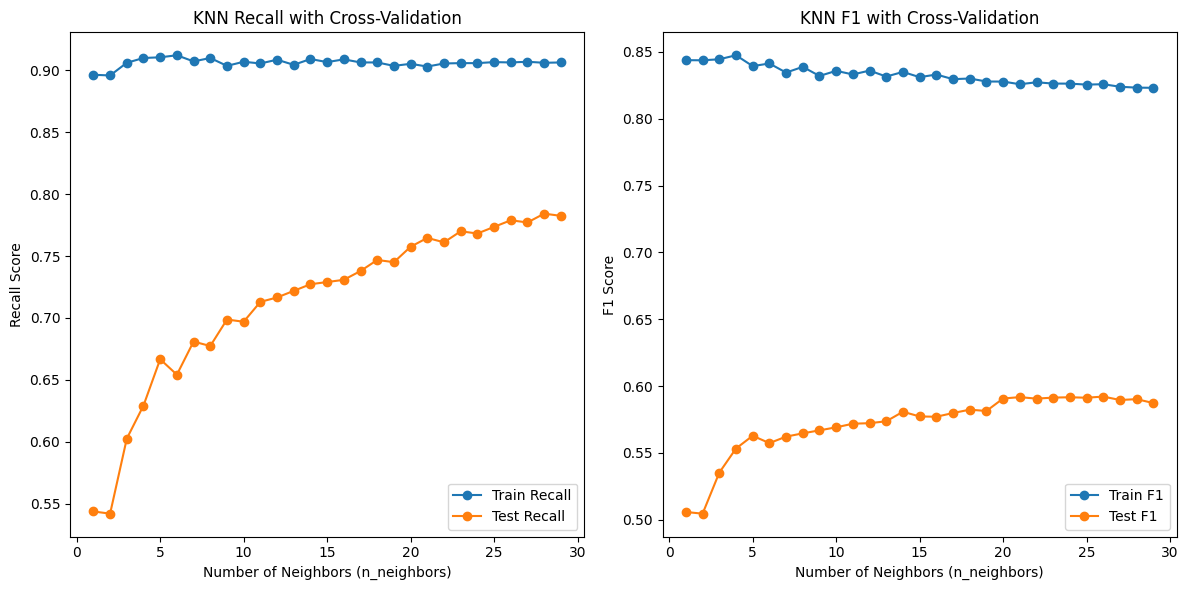

In [ ]:
values = [i for i in range(1, 30)]
train_recalls, test_recalls = list(), list()
train_f1s, test_f1s = list(), list()

cv = StratifiedKFold(n_splits=15)

for i in values:
    model = KNeighborsClassifier(n_neighbors=i, weights="distance", metric="minkowski")

    train_recalls_cv = cross_val_score(model, X_train_res, y_train_res, cv=cv, scoring="recall")
    train_recall = train_recalls_cv.mean()
    train_recalls.append(train_recall)

    train_f1s_cv = cross_val_score(model, X_train_res, y_train_res, cv=cv, scoring="f1")
    train_f1 = train_f1s_cv.mean()
    train_f1s.append(train_f1)

    model.fit(X_train_res, y_train_res)
    test_yhat = model.predict(X_test_sm)

    test_recall = recall_score(y_test_sm, test_yhat)
    test_recalls.append(test_recall)

    test_f1 = f1_score(y_test_sm, test_yhat)
    test_f1s.append(test_f1)

    print(">%d, train recall: %.3f, test recall: %.3f" % (i, train_recall, test_recall))
    print(">%d, train f1: %.3f, test f1: %.3f" % (i, train_f1, test_f1))
    recall_rentang = train_recall - test_recall
    f1_rentang = train_f1 - test_f1
    print(f"Recall Rentang adalah = {recall_rentang:.3f}")
    print(f"F1 Rentang adalah = {f1_rentang:.3f}")
    print("\n")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(values, train_recalls, "-o", label="Train Recall")
plt.plot(values, test_recalls, "-o", label="Test Recall")
plt.xlabel("Number of Neighbors (n_neighbors)")
plt.ylabel("Recall Score")
plt.legend()
plt.title("KNN Recall with Cross-Validation")

plt.subplot(1, 2, 2)
plt.plot(values, train_f1s, "-o", label="Train F1")
plt.plot(values, test_f1s, "-o", label="Test F1")
plt.xlabel("Number of Neighbors (n_neighbors)")
plt.ylabel("F1 Score")
plt.legend()
plt.title("KNN F1 with Cross-Validation")

plt.tight_layout()
plt.show()

## Untuk metric manhattan dan weight uniform

>1, train recall: 0.900, test recall: 0.531
>1, train f1: 0.845, test f1: 0.495
Recall Rentang adalah = 0.368
F1 Rentang adalah = 0.350


>2, train recall: 0.793, test recall: 0.401
>2, train f1: 0.818, test f1: 0.448
Recall Rentang adalah = 0.392
F1 Rentang adalah = 0.370


>3, train recall: 0.918, test recall: 0.670
>3, train f1: 0.849, test f1: 0.565
Recall Rentang adalah = 0.248
F1 Rentang adalah = 0.284


>4, train recall: 0.860, test recall: 0.592
>4, train f1: 0.837, test f1: 0.554
Recall Rentang adalah = 0.268
F1 Rentang adalah = 0.284


>5, train recall: 0.913, test recall: 0.709
>5, train f1: 0.838, test f1: 0.573
Recall Rentang adalah = 0.203
F1 Rentang adalah = 0.266


>6, train recall: 0.870, test recall: 0.647
>6, train f1: 0.833, test f1: 0.564
Recall Rentang adalah = 0.223
F1 Rentang adalah = 0.269


>7, train recall: 0.910, test recall: 0.743
>7, train f1: 0.833, test f1: 0.585
Recall Rentang adalah = 0.167
F1 Rentang adalah = 0.248


>8, train recall: 0.872, test reca

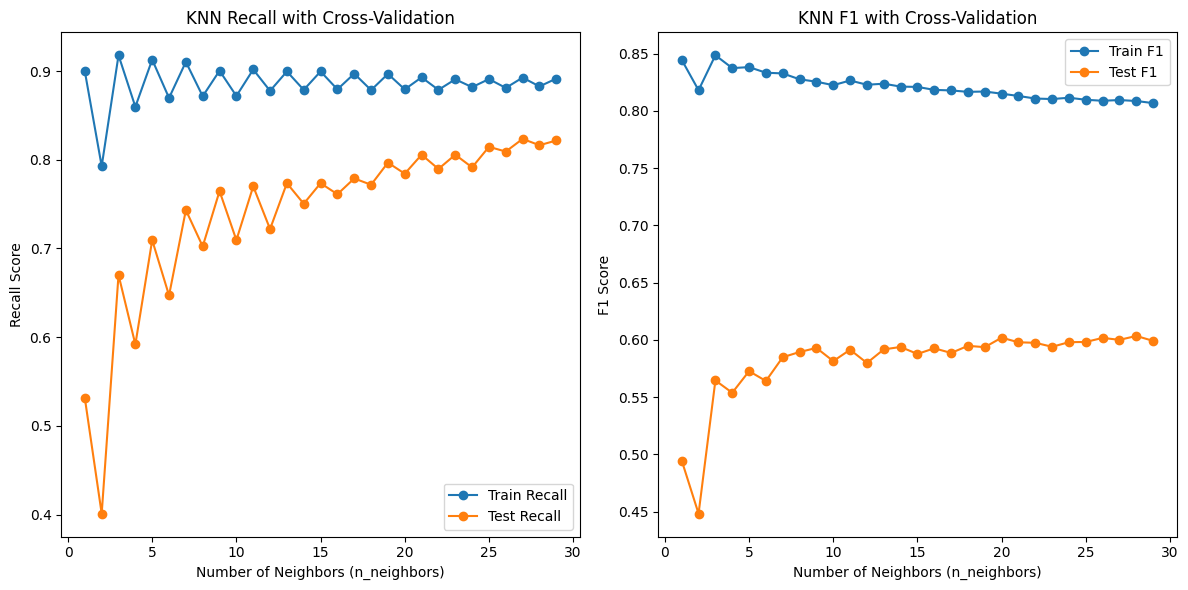

In [ ]:
values = [i for i in range(1, 30)]
train_recalls, test_recalls = list(), list()
train_f1s, test_f1s = list(), list()

cv = StratifiedKFold(n_splits=15)

for i in values:
    model = KNeighborsClassifier(n_neighbors=i, weights="uniform", metric="manhattan")

    train_recalls_cv = cross_val_score(model, X_train_res, y_train_res, cv=cv, scoring="recall")
    train_recall = train_recalls_cv.mean()
    train_recalls.append(train_recall)

    train_f1s_cv = cross_val_score(model, X_train_res, y_train_res, cv=cv, scoring="f1")
    train_f1 = train_f1s_cv.mean()
    train_f1s.append(train_f1)

    model.fit(X_train_res, y_train_res)
    test_yhat = model.predict(X_test_sm)

    test_recall = recall_score(y_test_sm, test_yhat)
    test_recalls.append(test_recall)

    test_f1 = f1_score(y_test_sm, test_yhat)
    test_f1s.append(test_f1)

    print(">%d, train recall: %.3f, test recall: %.3f" % (i, train_recall, test_recall))
    print(">%d, train f1: %.3f, test f1: %.3f" % (i, train_f1, test_f1))
    recall_rentang = train_recall - test_recall
    f1_rentang = train_f1 - test_f1
    print(f"Recall Rentang adalah = {recall_rentang:.3f}")
    print(f"F1 Rentang adalah = {f1_rentang:.3f}")
    print("\n")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(values, train_recalls, "-o", label="Train Recall")
plt.plot(values, test_recalls, "-o", label="Test Recall")
plt.xlabel("Number of Neighbors (n_neighbors)")
plt.ylabel("Recall Score")
plt.legend()
plt.title("KNN Recall with Cross-Validation")

plt.subplot(1, 2, 2)
plt.plot(values, train_f1s, "-o", label="Train F1")
plt.plot(values, test_f1s, "-o", label="Test F1")
plt.xlabel("Number of Neighbors (n_neighbors)")
plt.ylabel("F1 Score")
plt.legend()
plt.title("KNN F1 with Cross-Validation")

plt.tight_layout()
plt.show()

## Untuk metric manhattan dan weight distance

>1, train recall: 0.900, test recall: 0.531
>1, train f1: 0.845, test f1: 0.495
Recall Rentang adalah = 0.368
F1 Rentang adalah = 0.350


>2, train recall: 0.899, test recall: 0.529
>2, train f1: 0.844, test f1: 0.493
Recall Rentang adalah = 0.370
F1 Rentang adalah = 0.351


>3, train recall: 0.908, test recall: 0.608
>3, train f1: 0.848, test f1: 0.539
Recall Rentang adalah = 0.301
F1 Rentang adalah = 0.309


>4, train recall: 0.913, test recall: 0.624
>4, train f1: 0.849, test f1: 0.548
Recall Rentang adalah = 0.289
F1 Rentang adalah = 0.301


>5, train recall: 0.912, test recall: 0.661
>5, train f1: 0.842, test f1: 0.557
Recall Rentang adalah = 0.250
F1 Rentang adalah = 0.285


>6, train recall: 0.916, test recall: 0.663
>6, train f1: 0.844, test f1: 0.559
Recall Rentang adalah = 0.253
F1 Rentang adalah = 0.285


>7, train recall: 0.913, test recall: 0.690
>7, train f1: 0.840, test f1: 0.564
Recall Rentang adalah = 0.223
F1 Rentang adalah = 0.276


>8, train recall: 0.911, test reca

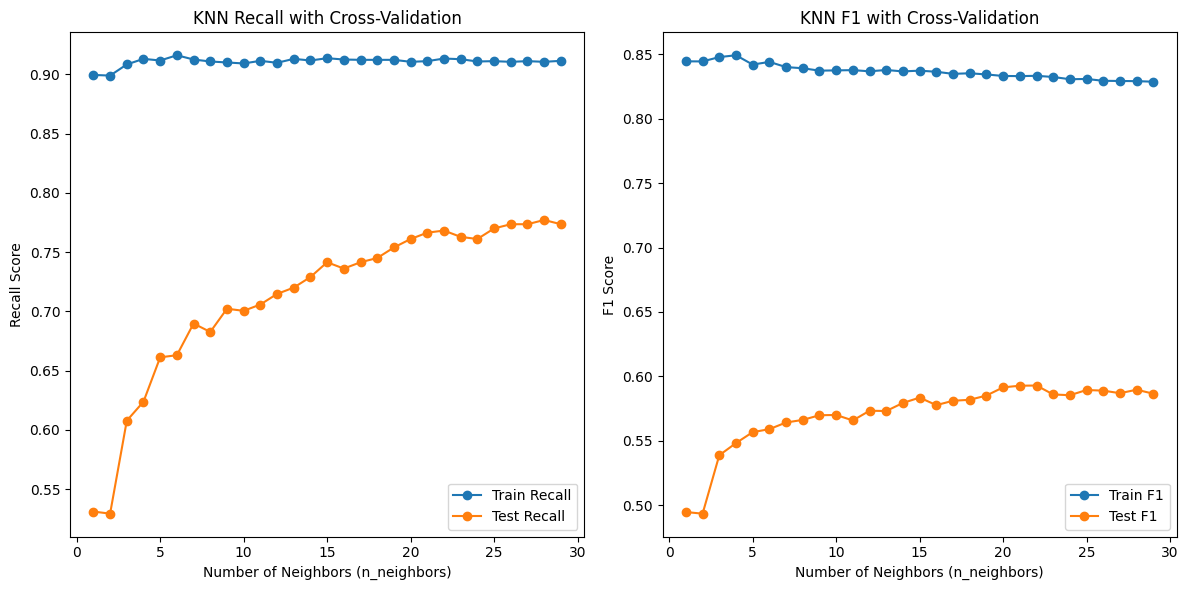

In [ ]:
values = [i for i in range(1, 30)]
train_recalls, test_recalls = list(), list()
train_f1s, test_f1s = list(), list()

cv = StratifiedKFold(n_splits=15)

for i in values:
    model = KNeighborsClassifier(n_neighbors=i, weights="distance", metric="manhattan")

    train_recalls_cv = cross_val_score(model, X_train_res, y_train_res, cv=cv, scoring="recall")
    train_recall = train_recalls_cv.mean()
    train_recalls.append(train_recall)

    train_f1s_cv = cross_val_score(model, X_train_res, y_train_res, cv=cv, scoring="f1")
    train_f1 = train_f1s_cv.mean()
    train_f1s.append(train_f1)

    model.fit(X_train_res, y_train_res)
    test_yhat = model.predict(X_test_sm)

    test_recall = recall_score(y_test_sm, test_yhat)
    test_recalls.append(test_recall)

    test_f1 = f1_score(y_test_sm, test_yhat)
    test_f1s.append(test_f1)

    print(">%d, train recall: %.3f, test recall: %.3f" % (i, train_recall, test_recall))
    print(">%d, train f1: %.3f, test f1: %.3f" % (i, train_f1, test_f1))
    recall_rentang = train_recall - test_recall
    f1_rentang = train_f1 - test_f1
    print(f"Recall Rentang adalah = {recall_rentang:.3f}")
    print(f"F1 Rentang adalah = {f1_rentang:.3f}")
    print("\n")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(values, train_recalls, "-o", label="Train Recall")
plt.plot(values, test_recalls, "-o", label="Test Recall")
plt.xlabel("Number of Neighbors (n_neighbors)")
plt.ylabel("Recall Score")
plt.legend()
plt.title("KNN Recall with Cross-Validation")

plt.subplot(1, 2, 2)
plt.plot(values, train_f1s, "-o", label="Train F1")
plt.plot(values, test_f1s, "-o", label="Test F1")
plt.xlabel("Number of Neighbors (n_neighbors)")
plt.ylabel("F1 Score")
plt.legend()
plt.title("KNN F1 with Cross-Validation")

plt.tight_layout()
plt.show()

## Untuk metric euclidean dan weight uniform

>1, train recall: 0.897, test recall: 0.544
>1, train f1: 0.844, test f1: 0.506
Recall Rentang adalah = 0.353
F1 Rentang adalah = 0.338


>2, train recall: 0.790, test recall: 0.399
>2, train f1: 0.815, test f1: 0.449
Recall Rentang adalah = 0.390
F1 Rentang adalah = 0.367


>3, train recall: 0.916, test recall: 0.663
>3, train f1: 0.847, test f1: 0.561
Recall Rentang adalah = 0.253
F1 Rentang adalah = 0.287


>4, train recall: 0.856, test recall: 0.594
>4, train f1: 0.834, test f1: 0.560
Recall Rentang adalah = 0.263
F1 Rentang adalah = 0.274


>5, train recall: 0.915, test recall: 0.704
>5, train f1: 0.839, test f1: 0.574
Recall Rentang adalah = 0.211
F1 Rentang adalah = 0.265


>6, train recall: 0.871, test recall: 0.633
>6, train f1: 0.833, test f1: 0.560
Recall Rentang adalah = 0.239
F1 Rentang adalah = 0.272


>7, train recall: 0.911, test recall: 0.731
>7, train f1: 0.832, test f1: 0.582
Recall Rentang adalah = 0.180
F1 Rentang adalah = 0.250


>8, train recall: 0.871, test reca

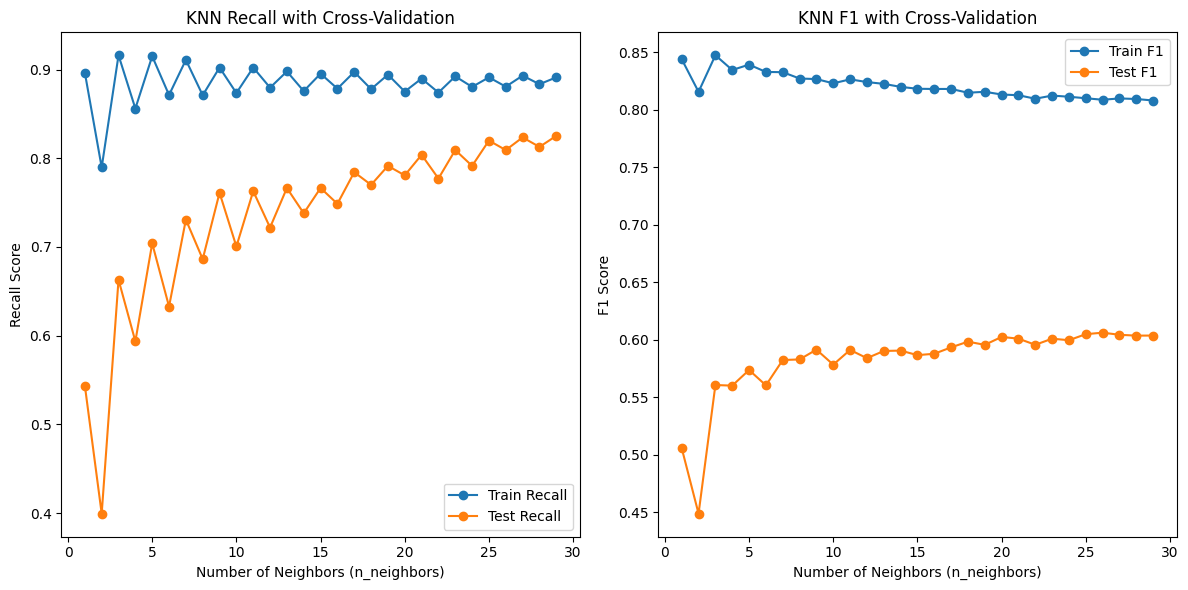

In [ ]:
values = [i for i in range(1, 30)]
train_recalls, test_recalls = list(), list()
train_f1s, test_f1s = list(), list()

cv = StratifiedKFold(n_splits=15)

for i in values:
    model = KNeighborsClassifier(n_neighbors=i, weights="uniform", metric="euclidean")

    train_recalls_cv = cross_val_score(model, X_train_res, y_train_res, cv=cv, scoring="recall")
    train_recall = train_recalls_cv.mean()
    train_recalls.append(train_recall)

    train_f1s_cv = cross_val_score(model, X_train_res, y_train_res, cv=cv, scoring="f1")
    train_f1 = train_f1s_cv.mean()
    train_f1s.append(train_f1)

    model.fit(X_train_res, y_train_res)
    test_yhat = model.predict(X_test_sm)

    test_recall = recall_score(y_test_sm, test_yhat)
    test_recalls.append(test_recall)

    test_f1 = f1_score(y_test_sm, test_yhat)
    test_f1s.append(test_f1)

    print(">%d, train recall: %.3f, test recall: %.3f" % (i, train_recall, test_recall))
    print(">%d, train f1: %.3f, test f1: %.3f" % (i, train_f1, test_f1))
    recall_rentang = train_recall - test_recall
    f1_rentang = train_f1 - test_f1
    print(f"Recall Rentang adalah = {recall_rentang:.3f}")
    print(f"F1 Rentang adalah = {f1_rentang:.3f}")
    print("\n")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(values, train_recalls, "-o", label="Train Recall")
plt.plot(values, test_recalls, "-o", label="Test Recall")
plt.xlabel("Number of Neighbors (n_neighbors)")
plt.ylabel("Recall Score")
plt.legend()
plt.title("KNN Recall with Cross-Validation")

plt.subplot(1, 2, 2)
plt.plot(values, train_f1s, "-o", label="Train F1")
plt.plot(values, test_f1s, "-o", label="Test F1")
plt.xlabel("Number of Neighbors (n_neighbors)")
plt.ylabel("F1 Score")
plt.legend()
plt.title("KNN F1 with Cross-Validation")

plt.tight_layout()
plt.show()

## Untuk metric euclidean dan weight distance

>1, train recall: 0.897, test recall: 0.544
>1, train f1: 0.844, test f1: 0.506
Recall Rentang adalah = 0.353
F1 Rentang adalah = 0.338


>2, train recall: 0.896, test recall: 0.542
>2, train f1: 0.844, test f1: 0.505
Recall Rentang adalah = 0.354
F1 Rentang adalah = 0.339


>3, train recall: 0.906, test recall: 0.602
>3, train f1: 0.844, test f1: 0.535
Recall Rentang adalah = 0.304
F1 Rentang adalah = 0.309


>4, train recall: 0.910, test recall: 0.629
>4, train f1: 0.847, test f1: 0.553
Recall Rentang adalah = 0.281
F1 Rentang adalah = 0.294


>5, train recall: 0.911, test recall: 0.667
>5, train f1: 0.839, test f1: 0.563
Recall Rentang adalah = 0.244
F1 Rentang adalah = 0.276


>6, train recall: 0.912, test recall: 0.654
>6, train f1: 0.841, test f1: 0.557
Recall Rentang adalah = 0.258
F1 Rentang adalah = 0.284


>7, train recall: 0.907, test recall: 0.681
>7, train f1: 0.834, test f1: 0.562
Recall Rentang adalah = 0.226
F1 Rentang adalah = 0.272


>8, train recall: 0.910, test reca

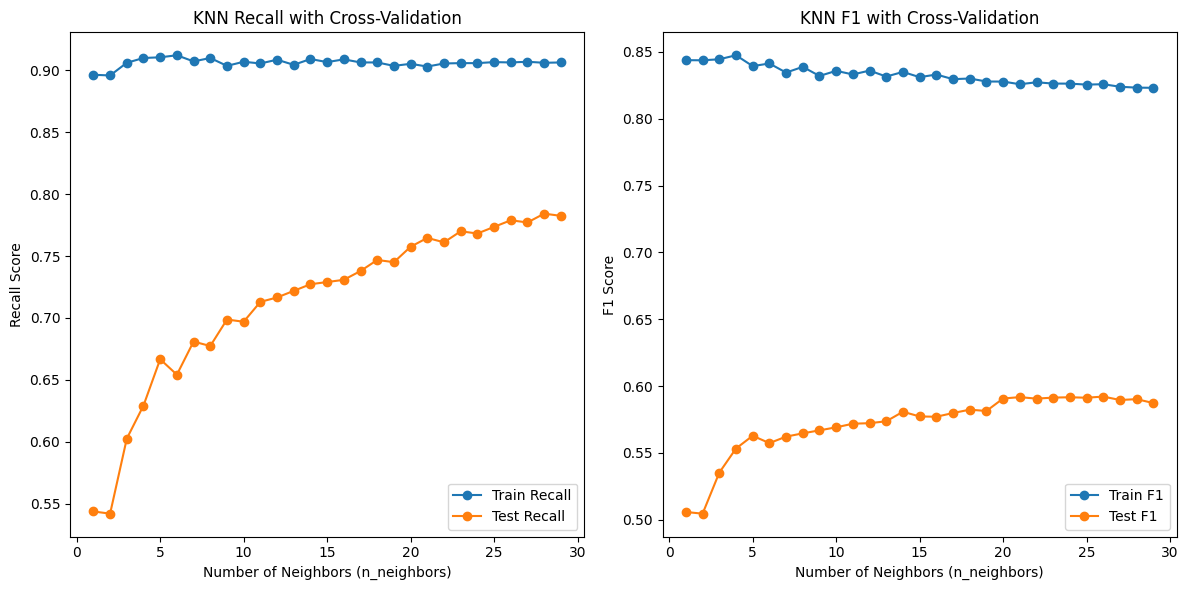

In [ ]:
values = [i for i in range(1, 30)]
train_recalls, test_recalls = list(), list()
train_f1s, test_f1s = list(), list()

cv = StratifiedKFold(n_splits=15)

for i in values:
    model = KNeighborsClassifier(n_neighbors=i, weights="distance", metric="euclidean")

    train_recalls_cv = cross_val_score(model, X_train_res, y_train_res, cv=cv, scoring="recall")
    train_recall = train_recalls_cv.mean()
    train_recalls.append(train_recall)

    train_f1s_cv = cross_val_score(model, X_train_res, y_train_res, cv=cv, scoring="f1")
    train_f1 = train_f1s_cv.mean()
    train_f1s.append(train_f1)

    model.fit(X_train_res, y_train_res)
    test_yhat = model.predict(X_test_sm)

    test_recall = recall_score(y_test_sm, test_yhat)
    test_recalls.append(test_recall)

    test_f1 = f1_score(y_test_sm, test_yhat)
    test_f1s.append(test_f1)

    print(">%d, train recall: %.3f, test recall: %.3f" % (i, train_recall, test_recall))
    print(">%d, train f1: %.3f, test f1: %.3f" % (i, train_f1, test_f1))
    recall_rentang = train_recall - test_recall
    f1_rentang = train_f1 - test_f1
    print(f"Recall Rentang adalah = {recall_rentang:.3f}")
    print(f"F1 Rentang adalah = {f1_rentang:.3f}")
    print("\n")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(values, train_recalls, "-o", label="Train Recall")
plt.plot(values, test_recalls, "-o", label="Test Recall")
plt.xlabel("Number of Neighbors (n_neighbors)")
plt.ylabel("Recall Score")
plt.legend()
plt.title("KNN Recall with Cross-Validation")

plt.subplot(1, 2, 2)
plt.plot(values, train_f1s, "-o", label="Train F1")
plt.plot(values, test_f1s, "-o", label="Test F1")
plt.xlabel("Number of Neighbors (n_neighbors)")
plt.ylabel("F1 Score")
plt.legend()
plt.title("KNN F1 with Cross-Validation")

plt.tight_layout()
plt.show()

# Hyperparameter tunning jika ingin recall sebagai acuan

## Bayesian Optimization

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['manhattan', 19, 'uniform'] before, using random point ['euclidean', 19, 'uniform']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['minkowski', 25, 'uniform'] before, using random point ['manhattan', 27, 'uniform']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['manhattan', 23, 'uniform'] before, using random point ['euclidean', 21, 'uniform']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['manhattan', 19, 'uniform'] before, using random point ['euclidean', 21, 'uniform']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: Us

Best Parameters: OrderedDict([('metric', 'manhattan'), ('n_neighbors', 19), ('weights', 'uniform')])


Recall: 0.7967914438502673


F1 Score: 0.593625498007968


Confusion Matrix:
[[1051  498]
 [ 114  447]]


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.68      0.77      1549
           1       0.47      0.80      0.59       561

    accuracy                           0.71      2110
   macro avg       0.69      0.74      0.68      2110
weighted avg       0.79      0.71      0.73      2110





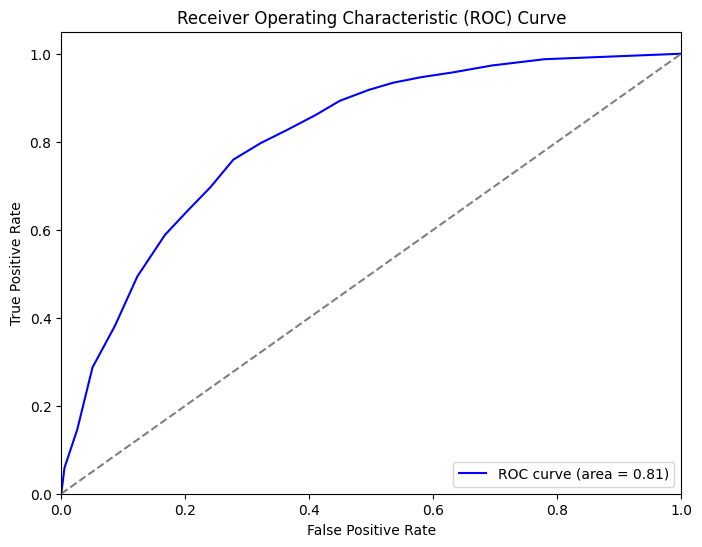

In [ ]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_sm, y_train_sm)
cv = StratifiedKFold(n_splits=15)

param_space = {
    "n_neighbors": Categorical([19, 21, 23, 25, 27]),
    "weights": Categorical(["uniform"]),
    "metric": Categorical(["euclidean", "manhattan", "minkowski"])
}

knn = KNeighborsClassifier()

bayes_search = BayesSearchCV(estimator=knn, search_spaces=param_space, n_iter=30, cv=cv, n_jobs=-1, random_state=42, scoring="recall")
bayes_search.fit(X_train_res, y_train_res)

best_knn = bayes_search.best_estimator_

y_pred = best_knn.predict(X_test_sm)

recall = recall_score(y_test_sm, y_pred)
f1 = f1_score(y_test_sm, y_pred)
conf_matrix = confusion_matrix(y_test_sm, y_pred)
class_report = classification_report(y_test_sm, y_pred)

print("=====================================")
print(f"Best Parameters: {bayes_search.best_params_}")
print("\n")
print(f"Recall: {recall}")
print("\n")
print(f"F1 Score: {f1}")
print("\n")
print(f"Confusion Matrix:\n{conf_matrix}")
print("\n")
print(f"Classification Report:\n{class_report}")
print("\n")

y_pred_prob = best_knn.predict_proba(X_test_sm)[:, 1]
fpr, tpr, _ = roc_curve(y_test_sm, y_pred_prob)
roc_auc = roc_auc_score(y_test_sm, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

## Grid Search

Accuracy: 0.7099526066350711
Recall: 0.7967914438502673
F1 Score: 0.593625498007968
Confusion Matrix:
 [[1051  498]
 [ 114  447]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.68      0.77      1549
           1       0.47      0.80      0.59       561

    accuracy                           0.71      2110
   macro avg       0.69      0.74      0.68      2110
weighted avg       0.79      0.71      0.73      2110



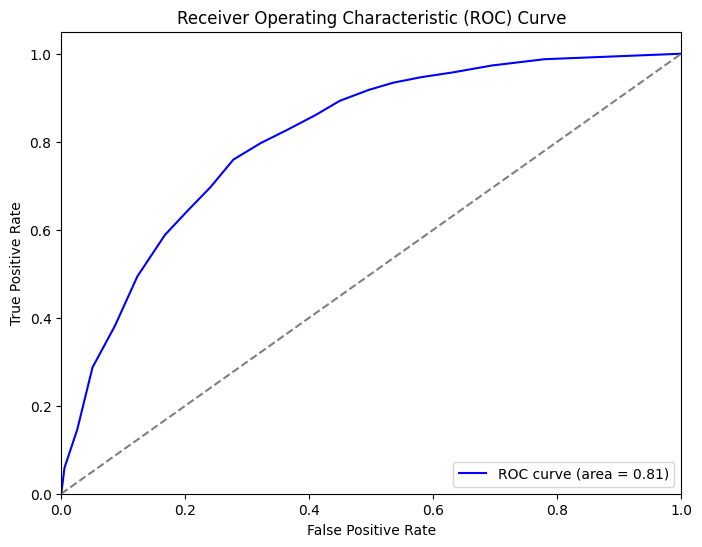

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'uniform'}


In [ ]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_sm, y_train_sm)
cv = StratifiedKFold(n_splits=15)

param_grid = {
    "n_neighbors": [19, 21, 23, 25, 27],
    "weights": ["uniform"],
    "metric": ["euclidean", "manhattan", "minkowski"]
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=cv, n_jobs=-1, scoring="recall")
grid_search.fit(X_train_res, y_train_res)

best_knn = grid_search.best_estimator_

y_pred = best_knn.predict(X_test_sm)

accuracy = accuracy_score(y_test_sm, y_pred)
recall = recall_score(y_test_sm, y_pred)
f1 = f1_score(y_test_sm, y_pred)
conf_matrix = confusion_matrix(y_test_sm, y_pred)
class_report = classification_report(y_test_sm, y_pred)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

y_pred_prob = best_knn.predict_proba(X_test_sm)[:, 1]
fpr, tpr, _ = roc_curve(y_test_sm, y_pred_prob)
roc_auc = roc_auc_score(y_test_sm, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

print("Best Parameters:", grid_search.best_params_)

## Random Search

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 15 is smaller than n_iter=30. Running 15 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Accuracy: 0.7099526066350711
Recall: 0.7967914438502673
F1 Score: 0.593625498007968
Confusion Matrix:
 [[1051  498]
 [ 114  447]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.68      0.77      1549
           1       0.47      0.80      0.59       561

    accuracy                           0.71      2110
   macro avg       0.69      0.74      0.68      2110
weighted avg       0.79      0.71      0.73      2110



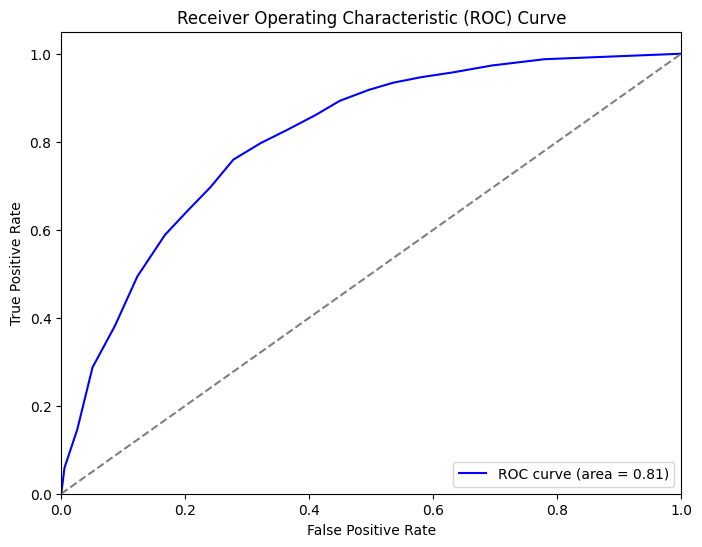

Best Parameters: {'weights': 'uniform', 'n_neighbors': 19, 'metric': 'manhattan'}


In [ ]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_sm, y_train_sm)
cv = StratifiedKFold(n_splits=15)

param_dist = {
    "n_neighbors": [19, 21, 23, 25, 27],
    "weights": ["uniform"],
    "metric": ["euclidean", "manhattan", "minkowski"]
}

knn = KNeighborsClassifier()

random_search = RandomizedSearchCV(estimator=knn, param_distributions=param_dist, n_iter=30, cv=StratifiedKFold(n_splits=15), n_jobs=-1, random_state=42, scoring="recall")
random_search.fit(X_train_res, y_train_res)

best_knn = random_search.best_estimator_

y_pred = best_knn.predict(X_test_sm)

accuracy = accuracy_score(y_test_sm, y_pred)
recall = recall_score(y_test_sm, y_pred)
f1 = f1_score(y_test_sm, y_pred)
conf_matrix = confusion_matrix(y_test_sm, y_pred)
class_report = classification_report(y_test_sm, y_pred)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

y_pred_prob = best_knn.predict_proba(X_test_sm)[:, 1]
fpr, tpr, _ = roc_curve(y_test_sm, y_pred_prob)
roc_auc = roc_auc_score(y_test_sm, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

print("Best Parameters:", random_search.best_params_)

# Hyperparameter tunning jika ingin f1 sebagai acuan

## Bayesian Optimization

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['manhattan', 21, 'uniform'] before, using random point ['manhattan', 21, 'distance']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['manhattan', 21, 'distance'] before, using random point ['euclidean', 25, 'distance']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['manhattan', 25, 'uniform'] before, using random point ['minkowski', 25, 'distance']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['euclidean', 25, 'uniform'] before, using random point ['euclidean', 25, 'distance']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:51

Best Parameters: OrderedDict([('metric', 'manhattan'), ('n_neighbors', 19), ('weights', 'distance')])


Recall: 0.7540106951871658


F1 Score: 0.5850622406639003


Confusion Matrix:
[[1087  462]
 [ 138  423]]


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.70      0.78      1549
           1       0.48      0.75      0.59       561

    accuracy                           0.72      2110
   macro avg       0.68      0.73      0.68      2110
weighted avg       0.78      0.72      0.73      2110





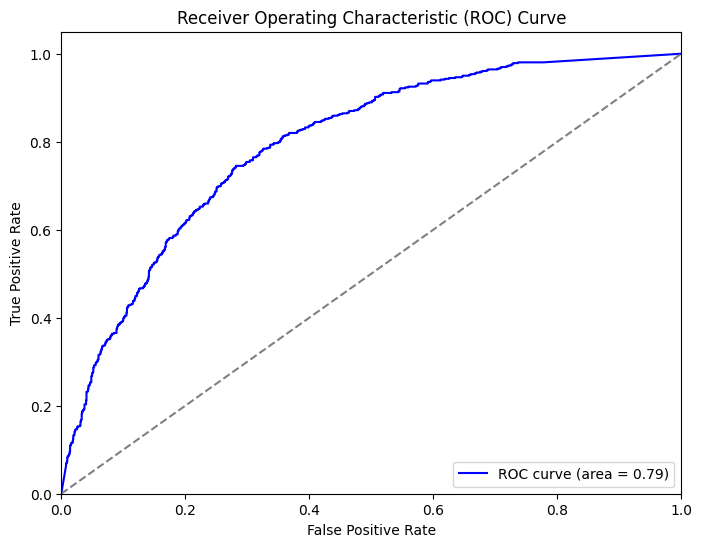

In [ ]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_sm, y_train_sm)
cv = StratifiedKFold(n_splits=15)

param_space = {
    "n_neighbors": Categorical([19, 21, 23, 25, 27]),
    "weights": Categorical(["uniform", "distance"]),
    "metric": Categorical(["euclidean", "manhattan", "minkowski"])
}

knn = KNeighborsClassifier()

bayes_search = BayesSearchCV(estimator=knn, search_spaces=param_space, n_iter=30, cv=cv, n_jobs=-1, random_state=42, scoring='f1')
bayes_search.fit(X_train_res, y_train_res)

best_knn = bayes_search.best_estimator_

y_pred = best_knn.predict(X_test_sm)

recall = recall_score(y_test_sm, y_pred)
f1 = f1_score(y_test_sm, y_pred)
conf_matrix = confusion_matrix(y_test_sm, y_pred)
class_report = classification_report(y_test_sm, y_pred)

print("=====================================")
print(f"Best Parameters: {bayes_search.best_params_}")
print("\n")
print(f"Recall: {recall}")
print("\n")
print(f"F1 Score: {f1}")
print("\n")
print(f"Confusion Matrix:\n{conf_matrix}")
print("\n")
print(f"Classification Report:\n{class_report}")
print("\n")

y_pred_prob = best_knn.predict_proba(X_test_sm)[:, 1]
fpr, tpr, _ = roc_curve(y_test_sm, y_pred_prob)
roc_auc = roc_auc_score(y_test_sm, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

## Grid Search

Accuracy: 0.7156398104265402
Recall: 0.7540106951871658
F1 Score: 0.5850622406639003
Confusion Matrix:
 [[1087  462]
 [ 138  423]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.70      0.78      1549
           1       0.48      0.75      0.59       561

    accuracy                           0.72      2110
   macro avg       0.68      0.73      0.68      2110
weighted avg       0.78      0.72      0.73      2110



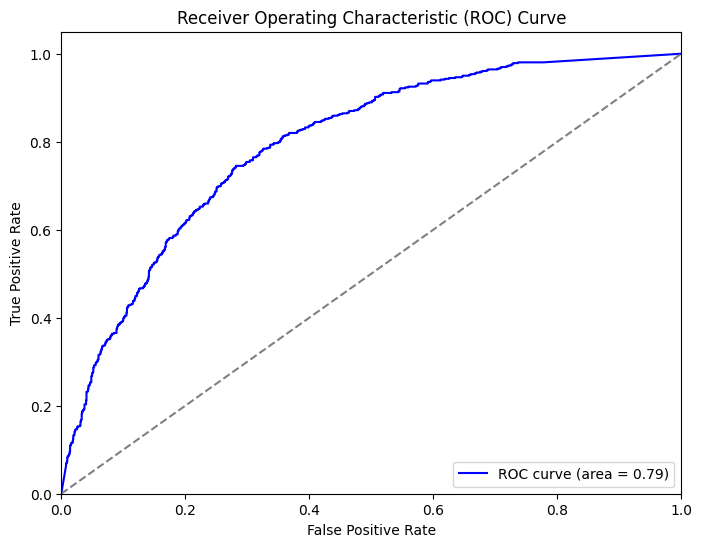

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}


In [ ]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_sm, y_train_sm)
cv = StratifiedKFold(n_splits=15)

param_grid = {
    "n_neighbors": [19, 21, 23, 25, 27],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan", "minkowski"]
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='f1')
grid_search.fit(X_train_res, y_train_res)

best_knn = grid_search.best_estimator_

y_pred = best_knn.predict(X_test_sm)

accuracy = accuracy_score(y_test_sm, y_pred)
recall = recall_score(y_test_sm, y_pred)
f1 = f1_score(y_test_sm, y_pred)
conf_matrix = confusion_matrix(y_test_sm, y_pred)
class_report = classification_report(y_test_sm, y_pred)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

y_pred_prob = best_knn.predict_proba(X_test_sm)[:, 1]
fpr, tpr, _ = roc_curve(y_test_sm, y_pred_prob)
roc_auc = roc_auc_score(y_test_sm, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

print("Best Parameters:", grid_search.best_params_)

## Random search

Accuracy: 0.7156398104265402
Recall: 0.7540106951871658
F1 Score: 0.5850622406639003
Confusion Matrix:
 [[1087  462]
 [ 138  423]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.70      0.78      1549
           1       0.48      0.75      0.59       561

    accuracy                           0.72      2110
   macro avg       0.68      0.73      0.68      2110
weighted avg       0.78      0.72      0.73      2110



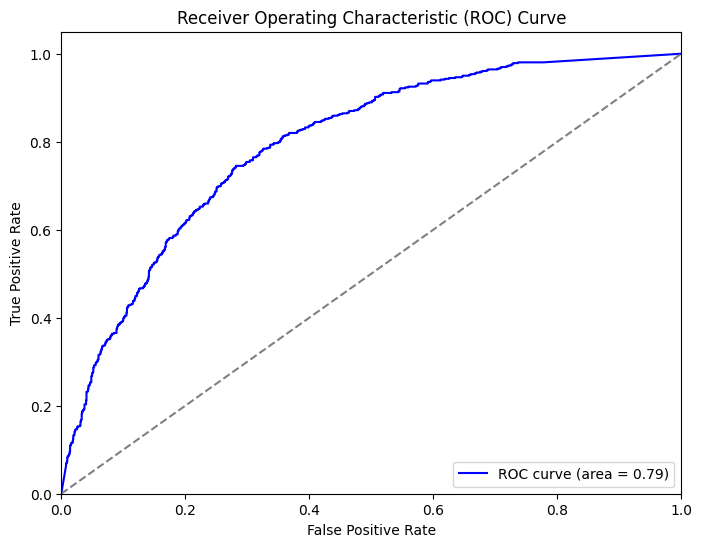

Best Parameters: {'weights': 'distance', 'n_neighbors': 19, 'metric': 'manhattan'}


In [ ]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_sm, y_train_sm)
cv = StratifiedKFold(n_splits=15)

param_dist = {
    "n_neighbors": [19, 21, 23, 25, 27],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan", "minkowski"]
}

knn = KNeighborsClassifier()

random_search = RandomizedSearchCV(estimator=knn, param_distributions=param_dist, n_iter=30, cv=StratifiedKFold(n_splits=15), n_jobs=-1, random_state=42, scoring='f1')
random_search.fit(X_train_res, y_train_res)

best_knn = random_search.best_estimator_

y_pred = best_knn.predict(X_test_sm)

accuracy = accuracy_score(y_test_sm, y_pred)
recall = recall_score(y_test_sm, y_pred)
f1 = f1_score(y_test_sm, y_pred)
conf_matrix = confusion_matrix(y_test_sm, y_pred)
class_report = classification_report(y_test_sm, y_pred)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

y_pred_prob = best_knn.predict_proba(X_test_sm)[:, 1]
fpr, tpr, _ = roc_curve(y_test_sm, y_pred_prob)
roc_auc = roc_auc_score(y_test_sm, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

print("Best Parameters:", random_search.best_params_)